参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sat Dec 17 18:05:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   48C    P0    39W / 300W |      9MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"

add_name = ""

In [4]:
# Parameters
add_name = "_tta_pseudo_hvflip_lb0771_09501_sim0000"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.95
cfg_pseudo_min = 0.1
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 30)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (8400, 24)


In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
pseudo_df.sort_values("target")

id    target
3283  698567d90  0.101208
4164  851d75528  0.199860
925   1e85f128e  0.206511
2153  44dd7e761  0.206812
5106  a474bef22  0.207187
...         ...       ...
1005  211108cc0  0.998498
5230  a8aaa9755  0.998518
1310  2a180c12a  0.998548
1522  3022e8994  0.998618
5975  bf3baa13d  0.998672

[7975 rows x 2 columns]

10.0 0.0


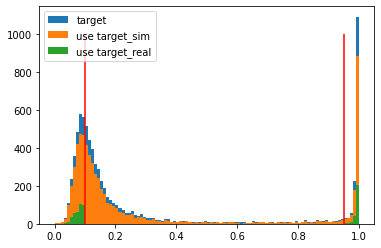

pseudo_df.shape: (7121, 30)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 最小値に外れ値があるのでclip
    pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())
    
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

9.0 1.0
add_pseudo_df.shape: (796, 18)


In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 1.0002549 -0.21894802
img.shape: (2, 360, 127)
y: 1


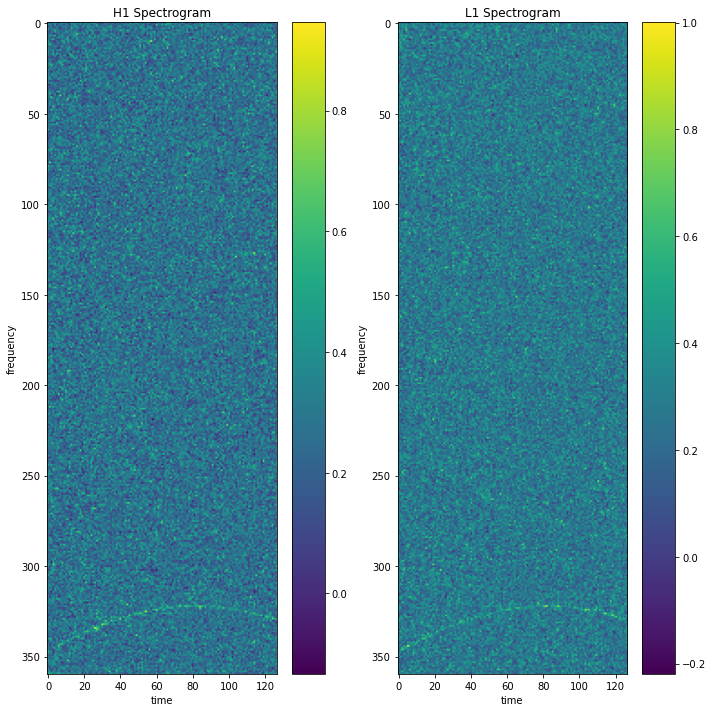

[[[0.44971025 0.16252708 0.3396818  ... 0.24264322 0.11276042 0.4107883 ]
  [0.24725094 0.4118723  0.23059693 ... 0.24997288 0.23415256 0.22710504]
  [0.11902289 0.24720445 0.27681237 ... 0.34308812 0.28023276 0.19170465]
  ...
  [0.33054477 0.31428644 0.02045508 ... 0.09948188 0.18245171 0.3011366 ]
  [0.34053308 0.42773312 0.14893036 ... 0.3935357  0.3616048  0.05848796]
  [0.5430526  0.49640983 0.46702746 ... 0.30012208 0.34397244 0.3321479 ]]

 [[0.21214582 0.26209342 0.16885151 ... 0.27298447 0.30382758 0.2832411 ]
  [0.5224413  0.26696116 0.448552   ... 0.5151964  0.30166286 0.29195964]
  [0.24528469 0.27230918 0.4841211  ... 0.2309489  0.41091308 0.31758085]
  ...
  [0.20720223 0.22778693 0.09281849 ... 0.18706869 0.23136936 0.1941786 ]
  [0.03403313 0.37081644 0.59807    ... 0.3584717  0.12601455 0.41445854]
  [0.2080872  0.3396802  0.24057066 ... 0.21791992 0.44527182 0.37495932]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

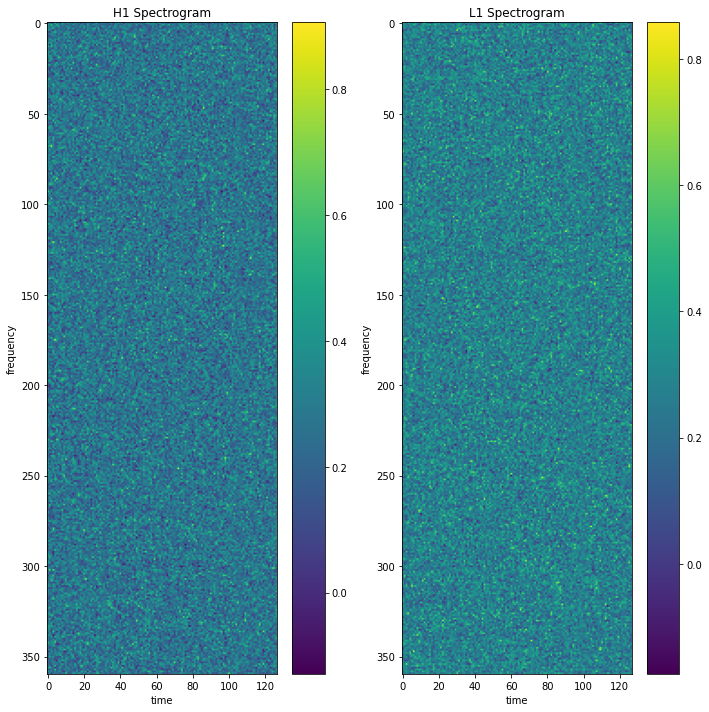

[[[0.12551664 0.35901338 0.05042097 ... 0.2269504  0.34996745 0.4311903 ]
  [0.44872817 0.33815646 0.6291179  ... 0.5058702  0.01808268 0.25889486]
  [0.30973297 0.33085173 0.291789   ... 0.36070693 0.15159506 0.28971624]
  ...
  [0.22795984 0.06764861 0.28786972 ... 0.19425727 0.04701063 0.3721978 ]
  [0.36845067 0.35606757 0.3286158  ... 0.5215793  0.36115724 0.24249946]
  [0.20977165 0.3328288  0.07055219 ... 0.34483507 0.12413195 0.2173584 ]]

 [[0.41395953 0.34280297 0.17165612 ... 0.22531468 0.17797309 0.16236436]
  [0.3116432  0.36478832 0.23055819 ... 0.40407714 0.35420194 0.22505967]
  [0.5068074  0.25160107 0.37014312 ... 0.41791722 0.09800076 0.20488824]
  ...
  [0.23054172 0.31986973 0.2847309  ... 0.3664388  0.40309787 0.1327067 ]
  [0.19656639 0.32463056 0.41589954 ... 0.0455485  0.29487577 0.24259712]
  [0.18551981 0.24523187 0.3179037  ... 0.3415907  0.38165691 0.2749132 ]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 50,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 1

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# Transform

In [35]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [36]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


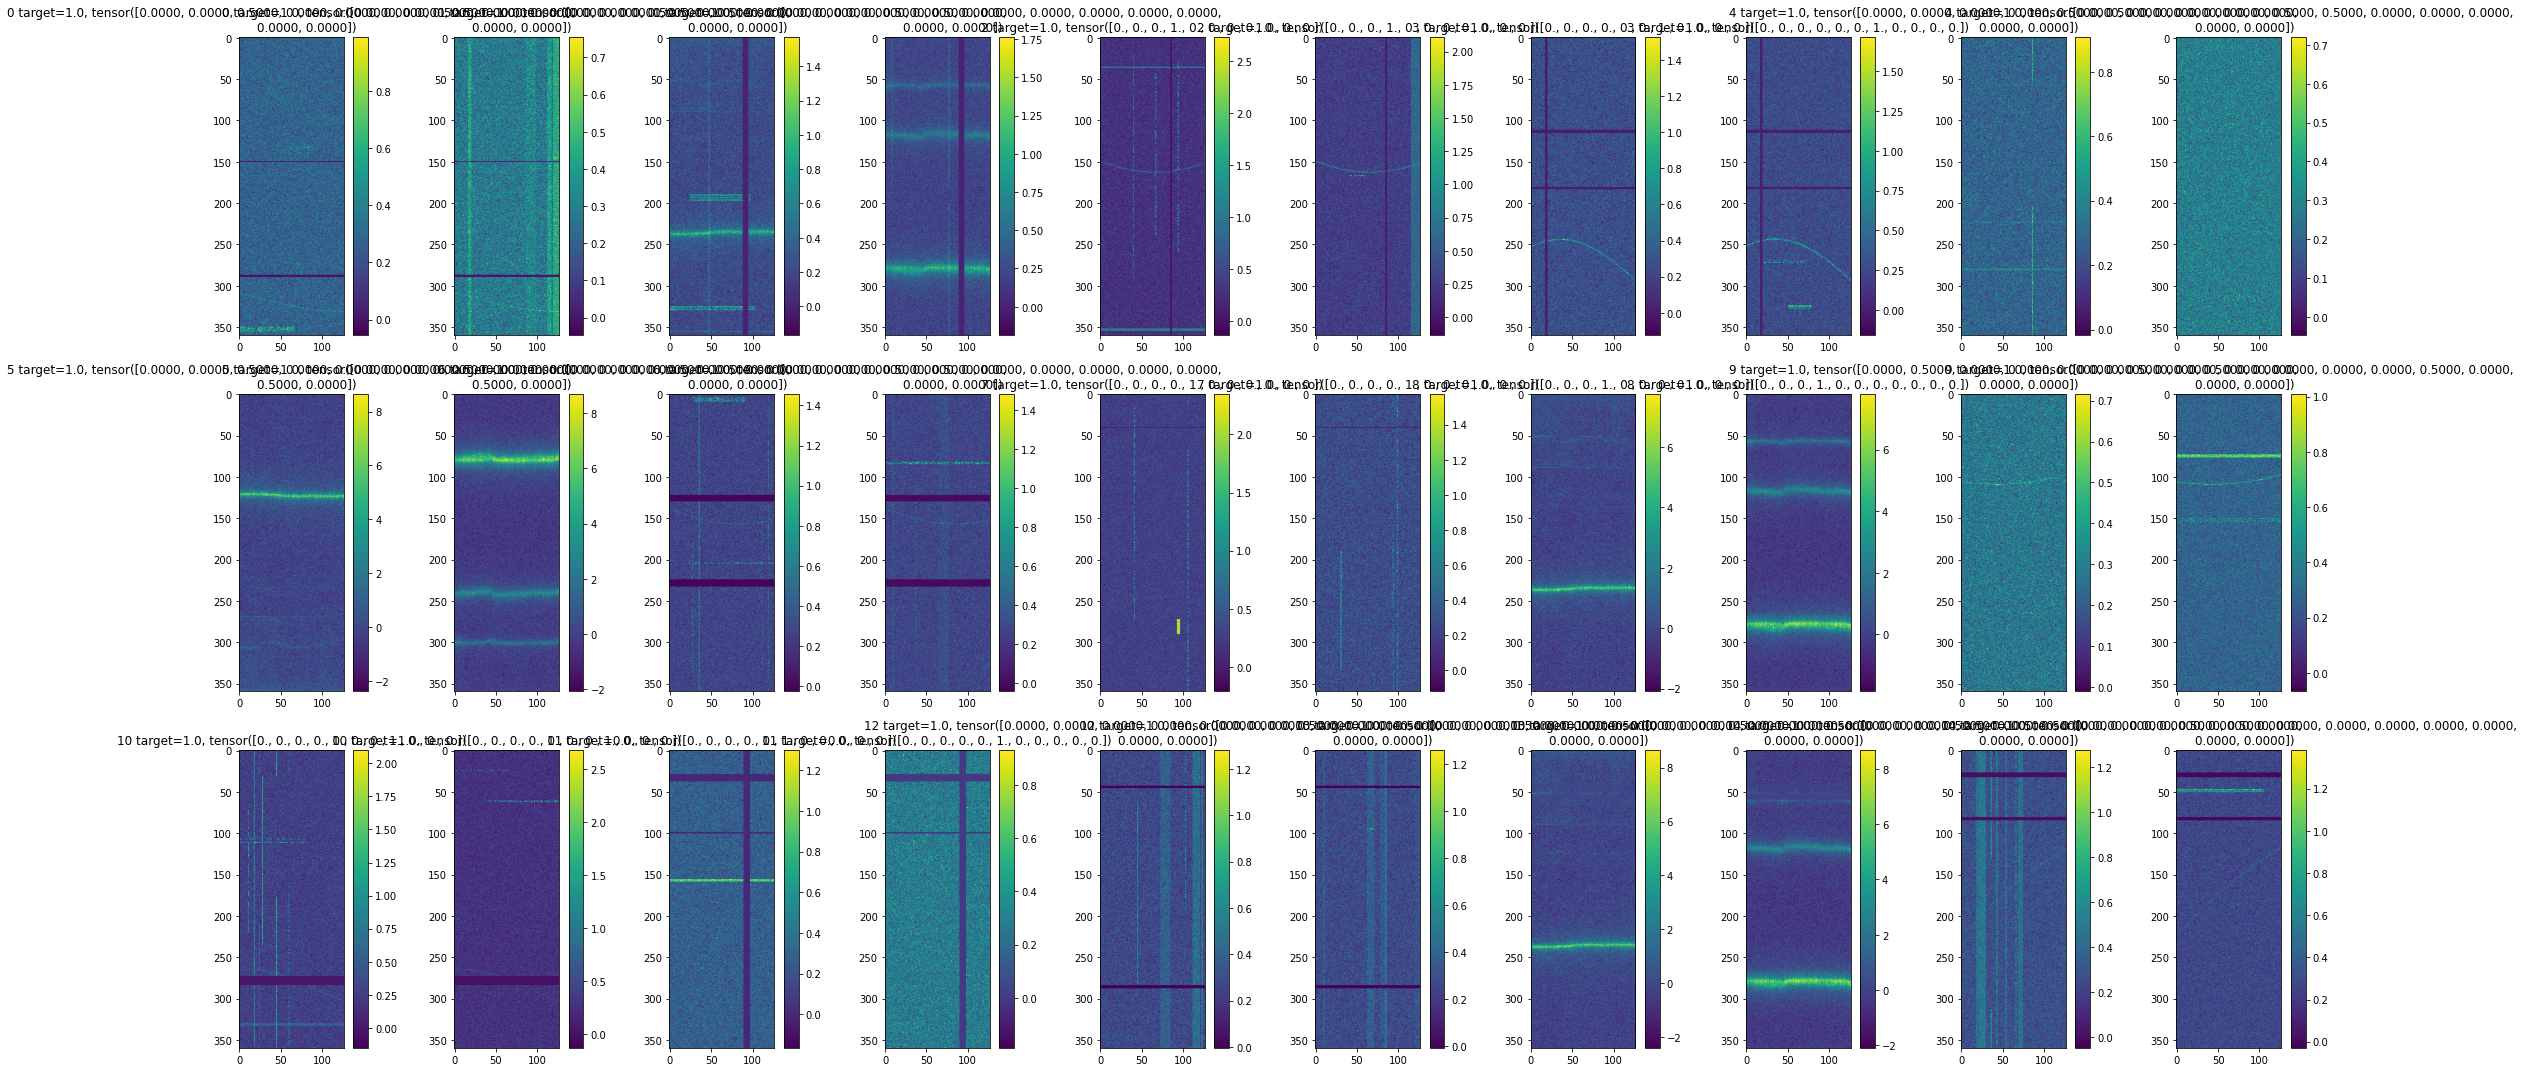

In [37]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [38]:
#%debug

In [39]:
#=====

# Model

In [40]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [41]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [43]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
#=====

In [45]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [46]:
#=====

In [47]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [52]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [53]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [54]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [55]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [56]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [57]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [58]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 24)
pseudo_df.shape: (7121, 30)
add_pseudo_df.shape: (796, 18)


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (16917, 38)
========== fold: 0, seed: 0 training ==========


Epoch: [1][0/236] Elapsed 0m 4s (remain 16m 40s) Loss: 1.5429(1.5429) Grad: 58057.0039  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.5303(1.5365) Grad: 55745.1992  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5582(1.5582) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.6021(1.5404) 


Epoch 1 - avg_train_loss: 1.5365  avg_val_loss: 1.5404  time: 127s
Epoch 1 - Score: 0.6679
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6679 Model
Epoch 1 - Save Best Loss: 1.5404 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.5285(1.5285) Grad: 57927.8320  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.4531(1.4189) Grad: 73433.9688  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3424(1.3424) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3821(1.3332) 


Epoch 2 - avg_train_loss: 1.4189  avg_val_loss: 1.3332  time: 125s
Epoch 2 - Score: 0.7961
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7961 Model
Epoch 2 - Save Best Loss: 1.3332 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 10m 48s) Loss: 1.3639(1.3639) Grad: 48135.4609  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3164(1.3767) Grad: 32247.8887  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.4152(1.4152) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.5857(1.3716) 


Epoch 3 - avg_train_loss: 1.3767  avg_val_loss: 1.3716  time: 126s
Epoch 3 - Score: 0.8277
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8277 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3549(1.3549) Grad: 52017.8516  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3390(1.3684) Grad: 31728.1172  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2536(1.2536) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.3777(1.2926) 


Epoch 4 - avg_train_loss: 1.3684  avg_val_loss: 1.2926  time: 127s
Epoch 4 - Score: 0.8187
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Loss: 1.2926 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3840(1.3840) Grad: 28663.4707  LR: 3.9961e-04  
Epoch: [5][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3114(1.3562) Grad: 22845.1992  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3257(1.3257) 


Epoch 5 - avg_train_loss: 1.3562  avg_val_loss: 1.3058  time: 126s
Epoch 5 - Score: 0.8416
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8416 Model


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5557(1.3058) 
Epoch: [6][0/236] Elapsed 0m 3s (remain 12m 9s) Loss: 1.4257(1.4257) Grad: 47046.9531  LR: 3.9844e-04  
Epoch: [6][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3440(1.3519) Grad: 21559.3867  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2791(1.2791) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3794(1.2817) 


Epoch 6 - avg_train_loss: 1.3519  avg_val_loss: 1.2817  time: 126s
Epoch 6 - Score: 0.8342
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Loss: 1.2817 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 11m 19s) Loss: 1.3409(1.3409) Grad: 24059.6543  LR: 3.9649e-04  
Epoch: [7][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3627(1.3475) Grad: 30812.3574  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2301(1.2301) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3522(1.2607) 


Epoch 7 - avg_train_loss: 1.3475  avg_val_loss: 1.2607  time: 126s
Epoch 7 - Score: 0.8474
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8474 Model
Epoch 7 - Save Best Loss: 1.2607 Model


Epoch: [8][0/236] Elapsed 0m 2s (remain 8m 6s) Loss: 1.4051(1.4051) Grad: 33499.0078  LR: 3.9378e-04  
Epoch: [8][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2938(1.3434) Grad: 25007.3223  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2418(1.2418) 
EVAL: [14/15] Elapsed 0m 4s (remain 0m 0s) Loss: 1.4231(1.2767) 


Epoch 8 - avg_train_loss: 1.3434  avg_val_loss: 1.2767  time: 126s
Epoch 8 - Score: 0.8496
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8496 Model


Epoch: [9][0/236] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3419(1.3419) Grad: 32767.0293  LR: 3.9031e-04  
Epoch: [9][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3453(1.3381) Grad: 44044.0430  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2270(1.2270) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3190(1.2665) 


Epoch 9 - avg_train_loss: 1.3381  avg_val_loss: 1.2665  time: 128s
Epoch 9 - Score: 0.8464
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/236] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3050(1.3050) Grad: 24342.9277  LR: 3.8610e-04  
Epoch: [10][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3232(1.3378) Grad: 25192.9824  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2533(1.2533) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4287(1.2800) 


Epoch 10 - avg_train_loss: 1.3378  avg_val_loss: 1.2800  time: 127s
Epoch 10 - Score: 0.8545
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Score: 0.8545 Model


Epoch: [11][0/236] Elapsed 0m 2s (remain 8m 42s) Loss: 1.3057(1.3057) Grad: 27214.4414  LR: 3.8116e-04  
Epoch: [11][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3247(1.3339) Grad: 20236.6504  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2911(1.2911) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3848(1.2888) 


Epoch 11 - avg_train_loss: 1.3339  avg_val_loss: 1.2888  time: 126s
Epoch 11 - Score: 0.8339
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/236] Elapsed 0m 2s (remain 10m 45s) Loss: 1.3221(1.3221) Grad: 22415.7949  LR: 3.7551e-04  
Epoch: [12][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.3451(1.3317) Grad: 22773.6680  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1839(1.1839) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2817(1.2424) 


Epoch 12 - avg_train_loss: 1.3317  avg_val_loss: 1.2424  time: 126s
Epoch 12 - Score: 0.8535
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 1.2424 Model


Epoch: [13][0/236] Elapsed 0m 2s (remain 9m 8s) Loss: 1.2754(1.2754) Grad: 18571.8770  LR: 3.6918e-04  
Epoch: [13][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3345(1.3330) Grad: 21498.3379  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2129(1.2129) 


Epoch 13 - avg_train_loss: 1.3330  avg_val_loss: 1.2429  time: 127s
Epoch 13 - Score: 0.8402
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2944(1.2429) 
Epoch: [14][0/236] Elapsed 0m 3s (remain 12m 12s) Loss: 1.3554(1.3554) Grad: 26798.9551  LR: 3.6219e-04  
Epoch: [14][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3505(1.3329) Grad: 28314.6992  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1692(1.1692) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2332(1.2342) 


Epoch 14 - avg_train_loss: 1.3329  avg_val_loss: 1.2342  time: 128s
Epoch 14 - Score: 0.8570
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Score: 0.8570 Model
Epoch 14 - Save Best Loss: 1.2342 Model


Epoch: [15][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3497(1.3497) Grad: 27776.3047  LR: 3.5456e-04  
Epoch: [15][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3331(1.3266) Grad: 40548.3633  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2587(1.2587) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3152(1.2578) 


Epoch 15 - avg_train_loss: 1.3266  avg_val_loss: 1.2578  time: 128s
Epoch 15 - Score: 0.8503
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/236] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3220(1.3220) Grad: 24633.2402  LR: 3.4634e-04  
Epoch: [16][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3552(1.3265) Grad: 24100.1035  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2426(1.2426) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2307(1.2497) 


Epoch 16 - avg_train_loss: 1.3265  avg_val_loss: 1.2497  time: 127s
Epoch 16 - Score: 0.8439
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3253(1.3253) Grad: 29029.8027  LR: 3.3754e-04  
Epoch: [17][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3309(1.3268) Grad: 26430.7441  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2655(1.2655) 


Epoch 17 - avg_train_loss: 1.3268  avg_val_loss: 1.2654  time: 127s
Epoch 17 - Score: 0.8384
Epoch 17 - lr: 3.2821e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2557(1.2654) 
Epoch: [18][0/236] Elapsed 0m 2s (remain 9m 25s) Loss: 1.3166(1.3166) Grad: 26170.2070  LR: 3.2821e-04  
Epoch: [18][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.3281(1.3233) Grad: 18442.6641  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2413(1.2413) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2654(1.2519) 


Epoch 18 - avg_train_loss: 1.3233  avg_val_loss: 1.2519  time: 126s
Epoch 18 - Score: 0.8346
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/236] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3638(1.3638) Grad: 19383.2207  LR: 3.1838e-04  
Epoch: [19][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.4683(1.3210) Grad: 38776.0898  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1957(1.1957) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1927(1.2414) 


Epoch 19 - avg_train_loss: 1.3210  avg_val_loss: 1.2414  time: 126s
Epoch 19 - Score: 0.8540
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/236] Elapsed 0m 3s (remain 12m 56s) Loss: 1.3670(1.3670) Grad: 31759.8262  LR: 3.0809e-04  
Epoch: [20][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3311(1.3196) Grad: 29419.3398  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 1.2003(1.2003) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2283(1.2320) 


Epoch 20 - avg_train_loss: 1.3196  avg_val_loss: 1.2320  time: 127s
Epoch 20 - Score: 0.8465
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 1.2320 Model


Epoch: [21][0/236] Elapsed 0m 3s (remain 12m 0s) Loss: 1.3728(1.3728) Grad: 24854.0293  LR: 2.9739e-04  
Epoch: [21][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3247(1.3206) Grad: 21925.2090  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2115(1.2115) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2766(1.2356) 


Epoch 21 - avg_train_loss: 1.3206  avg_val_loss: 1.2356  time: 127s
Epoch 21 - Score: 0.8442
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/236] Elapsed 0m 2s (remain 11m 33s) Loss: 1.2995(1.2995) Grad: 20440.4824  LR: 2.8630e-04  
Epoch: [22][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3327(1.3172) Grad: 25280.4375  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2202(1.2202) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3272(1.2261) 


Epoch 22 - avg_train_loss: 1.3172  avg_val_loss: 1.2261  time: 127s
Epoch 22 - Score: 0.8454
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 1.2261 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 11m 36s) Loss: 1.3629(1.3629) Grad: 29494.4004  LR: 2.7489e-04  
Epoch: [23][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3205(1.3149) Grad: 29094.5176  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2409(1.2409) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2946(1.2287) 


Epoch 23 - avg_train_loss: 1.3149  avg_val_loss: 1.2287  time: 126s
Epoch 23 - Score: 0.8454
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/236] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3019(1.3019) Grad: 21696.4062  LR: 2.6319e-04  
Epoch: [24][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2738(1.3197) Grad: 18040.3535  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2115(1.2115) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3673(1.2326) 


Epoch 24 - avg_train_loss: 1.3197  avg_val_loss: 1.2326  time: 127s
Epoch 24 - Score: 0.8496
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3030(1.3030) Grad: 23985.0879  LR: 2.5124e-04  
Epoch: [25][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2738(1.3154) Grad: 20516.6719  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2518(1.2518) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2880(1.2394) 


Epoch 25 - avg_train_loss: 1.3154  avg_val_loss: 1.2394  time: 127s
Epoch 25 - Score: 0.8439
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/236] Elapsed 0m 1s (remain 7m 47s) Loss: 1.3092(1.3092) Grad: 22232.7793  LR: 2.3910e-04  
Epoch: [26][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3566(1.3130) Grad: 33489.2930  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2164(1.2164) 


Epoch 26 - avg_train_loss: 1.3130  avg_val_loss: 1.2296  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2357(1.2296) 


Epoch 26 - Score: 0.8442
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.2694(1.2694) Grad: 19197.0840  LR: 2.2682e-04  
Epoch: [27][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3751(1.3103) Grad: 45018.0312  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2444(1.2444) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3022(1.2175) 


Epoch 27 - avg_train_loss: 1.3103  avg_val_loss: 1.2175  time: 127s
Epoch 27 - Score: 0.8426
Epoch 27 - lr: 2.1443e-04
Epoch 27 - Save Best Loss: 1.2175 Model


Epoch: [28][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3252(1.3252) Grad: 30664.8848  LR: 2.1443e-04  
Epoch: [28][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3678(1.3118) Grad: 35269.9336  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2007(1.2007) 


Epoch 28 - avg_train_loss: 1.3118  avg_val_loss: 1.2154  time: 126s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1520(1.2154) 


Epoch 28 - Score: 0.8505
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Loss: 1.2154 Model


Epoch: [29][0/236] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3003(1.3003) Grad: 23787.3105  LR: 2.0200e-04  
Epoch: [29][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3377(1.3144) Grad: 24668.2324  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2375(1.2375) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1870(1.2192) 


Epoch 29 - avg_train_loss: 1.3144  avg_val_loss: 1.2192  time: 126s
Epoch 29 - Score: 0.8419
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/236] Elapsed 0m 2s (remain 10m 26s) Loss: 1.2843(1.2843) Grad: 16818.7773  LR: 1.8957e-04  
Epoch: [30][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2537(1.3103) Grad: 23798.9668  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2255(1.2255) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2911(1.2303) 


Epoch 30 - avg_train_loss: 1.3103  avg_val_loss: 1.2303  time: 128s
Epoch 30 - Score: 0.8463
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3068(1.3068) Grad: 30397.1973  LR: 1.7718e-04  
Epoch: [31][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2972(1.3091) Grad: 30254.5312  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2168(1.2168) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1193(1.2259) 


Epoch 31 - avg_train_loss: 1.3091  avg_val_loss: 1.2259  time: 126s
Epoch 31 - Score: 0.8472
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/236] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2343(1.2343) Grad: 27820.1465  LR: 1.6490e-04  
Epoch: [32][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3020(1.3083) Grad: 20549.8398  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2272(1.2272) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2028(1.2460) 


Epoch 32 - avg_train_loss: 1.3083  avg_val_loss: 1.2460  time: 127s
Epoch 32 - Score: 0.8467
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/236] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3516(1.3516) Grad: 31653.7949  LR: 1.5276e-04  
Epoch: [33][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3114(1.3048) Grad: 13939.9189  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2119(1.2119) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1493(1.2280) 


Epoch 33 - avg_train_loss: 1.3048  avg_val_loss: 1.2280  time: 127s
Epoch 33 - Score: 0.8465
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3372(1.3372) Grad: 25365.7480  LR: 1.4081e-04  
Epoch: [34][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2983(1.3041) Grad: 21976.1172  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2414(1.2414) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1834(1.2751) 


Epoch 34 - avg_train_loss: 1.3041  avg_val_loss: 1.2751  time: 128s
Epoch 34 - Score: 0.8456
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/236] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3496(1.3496) Grad: 23597.5195  LR: 1.2911e-04  
Epoch: [35][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3097(1.3027) Grad: 26232.5801  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2434(1.2434) 


Epoch 35 - avg_train_loss: 1.3027  avg_val_loss: 1.2157  time: 128s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1721(1.2157) 


Epoch 35 - Score: 0.8368
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/236] Elapsed 0m 2s (remain 11m 24s) Loss: 1.2917(1.2917) Grad: 28345.8027  LR: 1.1770e-04  
Epoch: [36][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3255(1.3039) Grad: 36974.2578  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1973(1.1973) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2300(1.2326) 


Epoch 36 - avg_train_loss: 1.3039  avg_val_loss: 1.2326  time: 128s
Epoch 36 - Score: 0.8593
Epoch 36 - lr: 1.0661e-04
Epoch 36 - Save Best Score: 0.8593 Model


Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 20s) Loss: 1.2572(1.2572) Grad: 22166.6445  LR: 1.0661e-04  
Epoch: [37][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.3076(1.3036) Grad: 27907.0586  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2093(1.2093) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1036(1.2022) 


Epoch 37 - avg_train_loss: 1.3036  avg_val_loss: 1.2022  time: 126s
Epoch 37 - Score: 0.8458
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 1.2022 Model


Epoch: [38][0/236] Elapsed 0m 2s (remain 10m 36s) Loss: 1.2852(1.2852) Grad: 22892.7578  LR: 9.5906e-05  
Epoch: [38][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2903(1.3023) Grad: 29815.1641  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2081(1.2081) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2044(1.2062) 


Epoch 38 - avg_train_loss: 1.3023  avg_val_loss: 1.2062  time: 128s
Epoch 38 - Score: 0.8405
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/236] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3067(1.3067) Grad: 29352.7891  LR: 8.5619e-05  
Epoch: [39][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3044(1.3022) Grad: 24158.6934  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2015(1.2015) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1834(1.2008) 


Epoch 39 - avg_train_loss: 1.3022  avg_val_loss: 1.2008  time: 127s
Epoch 39 - Score: 0.8459
Epoch 39 - lr: 7.5790e-05
Epoch 39 - Save Best Loss: 1.2008 Model


Epoch: [40][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3047(1.3047) Grad: 26136.8574  LR: 7.5790e-05  
Epoch: [40][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2441(1.2978) Grad: 22207.9375  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1989(1.1989) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1514(1.2013) 


Epoch 40 - avg_train_loss: 1.2978  avg_val_loss: 1.2013  time: 127s
Epoch 40 - Score: 0.8412
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/236] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3563(1.3563) Grad: 24287.2598  LR: 6.6460e-05  
Epoch: [41][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2129(1.3007) Grad: 20428.6387  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2124(1.2124) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1294(1.2063) 


Epoch 41 - avg_train_loss: 1.3007  avg_val_loss: 1.2063  time: 127s
Epoch 41 - Score: 0.8470
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/236] Elapsed 0m 2s (remain 10m 30s) Loss: 1.3085(1.3085) Grad: 29616.7461  LR: 5.7664e-05  
Epoch: [42][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3232(1.2994) Grad: 25910.6211  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1942(1.1942) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1458(1.2032) 


Epoch 42 - avg_train_loss: 1.2994  avg_val_loss: 1.2032  time: 126s
Epoch 42 - Score: 0.8453
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/236] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3363(1.3363) Grad: 24328.2148  LR: 4.9438e-05  
Epoch: [43][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2865(1.2946) Grad: 22570.2344  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2157(1.2157) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1804(1.2142) 


Epoch 43 - avg_train_loss: 1.2946  avg_val_loss: 1.2142  time: 127s
Epoch 43 - Score: 0.8501
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/236] Elapsed 0m 2s (remain 10m 55s) Loss: 1.2792(1.2792) Grad: 24457.7949  LR: 4.1815e-05  
Epoch: [44][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3338(1.2973) Grad: 25520.6035  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1948(1.1948) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1500(1.2041) 


Epoch 44 - avg_train_loss: 1.2973  avg_val_loss: 1.2041  time: 127s
Epoch 44 - Score: 0.8405
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/236] Elapsed 0m 2s (remain 11m 25s) Loss: 1.2502(1.2502) Grad: 30419.8027  LR: 3.4823e-05  
Epoch: [45][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2284(1.2960) Grad: 21072.9844  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1997(1.1997) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2000(1.2043) 


Epoch 45 - avg_train_loss: 1.2960  avg_val_loss: 1.2043  time: 128s
Epoch 45 - Score: 0.8407
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/236] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2865(1.2865) Grad: 29194.1250  LR: 2.8491e-05  
Epoch: [46][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3488(1.2953) Grad: 36757.0898  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1936(1.1936) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1392(1.2006) 


Epoch 46 - avg_train_loss: 1.2953  avg_val_loss: 1.2006  time: 128s
Epoch 46 - Score: 0.8445
Epoch 46 - lr: 2.2844e-05
Epoch 46 - Save Best Loss: 1.2006 Model


Epoch: [47][0/236] Elapsed 0m 2s (remain 11m 12s) Loss: 1.2962(1.2962) Grad: 24834.3301  LR: 2.2844e-05  
Epoch: [47][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2800(1.2952) Grad: 28904.9238  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1972(1.1972) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1824(1.1966) 


Epoch 47 - avg_train_loss: 1.2952  avg_val_loss: 1.1966  time: 128s
Epoch 47 - Score: 0.8432
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Loss: 1.1966 Model


Epoch: [48][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2565(1.2565) Grad: 22977.5488  LR: 1.7904e-05  
Epoch: [48][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2912(1.2911) Grad: 22552.8398  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2108(1.2108) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1638(1.2138) 


Epoch 48 - avg_train_loss: 1.2911  avg_val_loss: 1.2138  time: 126s
Epoch 48 - Score: 0.8496
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/236] Elapsed 0m 3s (remain 12m 11s) Loss: 1.3003(1.3003) Grad: 23331.1543  LR: 1.3691e-05  
Epoch: [49][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2971(1.2975) Grad: 22184.9902  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2124(1.2124) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1653(1.2173) 


Epoch 49 - avg_train_loss: 1.2975  avg_val_loss: 1.2173  time: 127s
Epoch 49 - Score: 0.8463
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.3048(1.3048) Grad: 23963.1719  LR: 1.0221e-05  
Epoch: [50][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3008(1.2969) Grad: 33240.7422  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1810(1.1810) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1416(1.2254) 


Epoch 50 - avg_train_loss: 1.2969  avg_val_loss: 1.2254  time: 127s
Epoch 50 - Score: 0.8548
Epoch 50 - lr: 7.5071e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8593
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/236] Elapsed 0m 2s (remain 10m 12s) Loss: 1.5390(1.5390) Grad: 55855.3633  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.5341(1.5405) Grad: 60768.7500  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.5688(1.5688) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5323(1.5431) 


Epoch 1 - avg_train_loss: 1.5405  avg_val_loss: 1.5431  time: 127s
Epoch 1 - Score: 0.6282
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6282 Model
Epoch 1 - Save Best Loss: 1.5431 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 10m 19s) Loss: 1.5348(1.5348) Grad: 56336.1406  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3938(1.4226) Grad: 54844.9023  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4304(1.4304) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3569(1.3570) 


Epoch 2 - avg_train_loss: 1.4226  avg_val_loss: 1.3570  time: 128s
Epoch 2 - Score: 0.7933
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7933 Model
Epoch 2 - Save Best Loss: 1.3570 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3842(1.3842) Grad: 57266.9570  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3678(1.3750) Grad: 30300.9766  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.4071(1.4071) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4836(1.3313) 


Epoch 3 - avg_train_loss: 1.3750  avg_val_loss: 1.3313  time: 128s
Epoch 3 - Score: 0.8114
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8114 Model
Epoch 3 - Save Best Loss: 1.3313 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 11m 14s) Loss: 1.3736(1.3736) Grad: 50006.9023  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3722(1.3667) Grad: 28029.9102  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2822(1.2822) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2038(1.3073) 


Epoch 4 - avg_train_loss: 1.3667  avg_val_loss: 1.3073  time: 127s
Epoch 4 - Score: 0.8363
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8363 Model
Epoch 4 - Save Best Loss: 1.3073 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 36s) Loss: 1.4024(1.4024) Grad: 46950.4883  LR: 3.9961e-04  
Epoch: [5][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3561(1.3595) Grad: 24230.7539  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3765(1.3765) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3700(1.3002) 


Epoch 5 - avg_train_loss: 1.3595  avg_val_loss: 1.3002  time: 128s
Epoch 5 - Score: 0.8244
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Loss: 1.3002 Model


Epoch: [6][0/236] Elapsed 0m 2s (remain 11m 24s) Loss: 1.3523(1.3523) Grad: 27567.1602  LR: 3.9844e-04  
Epoch: [6][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3917(1.3535) Grad: 46410.3281  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2778(1.2778) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2581(1.2860) 


Epoch 6 - avg_train_loss: 1.3535  avg_val_loss: 1.2860  time: 127s
Epoch 6 - Score: 0.8414
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8414 Model
Epoch 6 - Save Best Loss: 1.2860 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3462(1.3462) Grad: 34406.5469  LR: 3.9649e-04  
Epoch: [7][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3847(1.3488) Grad: 32768.9883  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2929(1.2929) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1677(1.2806) 


Epoch 7 - avg_train_loss: 1.3488  avg_val_loss: 1.2806  time: 126s
Epoch 7 - Score: 0.8345
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 1.2806 Model


Epoch: [8][0/236] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3309(1.3309) Grad: 23248.0703  LR: 3.9378e-04  
Epoch: [8][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3316(1.3425) Grad: 25823.6094  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3699(1.3699) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4073(1.2929) 


Epoch 8 - avg_train_loss: 1.3425  avg_val_loss: 1.2929  time: 127s
Epoch 8 - Score: 0.8454
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8454 Model


Epoch: [9][0/236] Elapsed 0m 2s (remain 11m 1s) Loss: 1.3237(1.3237) Grad: 43478.9297  LR: 3.9031e-04  
Epoch: [9][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3336(1.3407) Grad: 20241.2559  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2736(1.2736) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1572(1.2678) 


Epoch 9 - avg_train_loss: 1.3407  avg_val_loss: 1.2678  time: 128s
Epoch 9 - Score: 0.8257
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Loss: 1.2678 Model


Epoch: [10][0/236] Elapsed 0m 2s (remain 11m 40s) Loss: 1.3577(1.3577) Grad: 26221.0664  LR: 3.8610e-04  
Epoch: [10][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3184(1.3384) Grad: 24171.4785  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3424(1.3424) 


Epoch 10 - avg_train_loss: 1.3384  avg_val_loss: 1.2986  time: 128s
Epoch 10 - Score: 0.8392
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3794(1.2986) 
Epoch: [11][0/236] Elapsed 0m 2s (remain 10m 39s) Loss: 1.2978(1.2978) Grad: 21921.5391  LR: 3.8116e-04  
Epoch: [11][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.4241(1.3351) Grad: 28238.0723  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3997(1.3997) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3943(1.3213) 


Epoch 11 - avg_train_loss: 1.3351  avg_val_loss: 1.3213  time: 128s
Epoch 11 - Score: 0.8338
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/236] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3290(1.3290) Grad: 18719.7148  LR: 3.7551e-04  
Epoch: [12][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3317(1.3315) Grad: 27080.6484  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2885(1.2885) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4828(1.2505) 


Epoch 12 - avg_train_loss: 1.3315  avg_val_loss: 1.2505  time: 126s
Epoch 12 - Score: 0.8353
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 1.2505 Model


Epoch: [13][0/236] Elapsed 0m 2s (remain 8m 19s) Loss: 1.2948(1.2948) Grad: 22515.4316  LR: 3.6918e-04  
Epoch: [13][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3161(1.3312) Grad: 19044.9004  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3127(1.3127) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2598(1.2636) 


Epoch 13 - avg_train_loss: 1.3312  avg_val_loss: 1.2636  time: 127s
Epoch 13 - Score: 0.8419
Epoch 13 - lr: 3.6219e-04


Epoch: [14][0/236] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3386(1.3386) Grad: 30342.1328  LR: 3.6219e-04  
Epoch: [14][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2844(1.3288) Grad: 19629.2090  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2973(1.2973) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2880(1.2654) 


Epoch 14 - avg_train_loss: 1.3288  avg_val_loss: 1.2654  time: 127s
Epoch 14 - Score: 0.8408
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/236] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2981(1.2981) Grad: 20934.3203  LR: 3.5456e-04  
Epoch: [15][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3688(1.3300) Grad: 30744.8379  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2712(1.2712) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2192(1.2378) 


Epoch 15 - avg_train_loss: 1.3300  avg_val_loss: 1.2378  time: 126s
Epoch 15 - Score: 0.8478
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8478 Model
Epoch 15 - Save Best Loss: 1.2378 Model


Epoch: [16][0/236] Elapsed 0m 3s (remain 12m 58s) Loss: 1.3254(1.3254) Grad: 26319.3750  LR: 3.4634e-04  
Epoch: [16][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3434(1.3292) Grad: 31439.1230  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2621(1.2621) 


Epoch 16 - avg_train_loss: 1.3292  avg_val_loss: 1.2419  time: 128s
Epoch 16 - Score: 0.8433
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3834(1.2419) 
Epoch: [17][0/236] Elapsed 0m 2s (remain 10m 36s) Loss: 1.3125(1.3125) Grad: 22367.5020  LR: 3.3754e-04  
Epoch: [17][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3621(1.3263) Grad: 35934.5352  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2598(1.2598) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2278(1.2354) 


Epoch 17 - avg_train_loss: 1.3263  avg_val_loss: 1.2354  time: 128s
Epoch 17 - Score: 0.8425
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 1.2354 Model


Epoch: [18][0/236] Elapsed 0m 2s (remain 11m 25s) Loss: 1.2723(1.2723) Grad: 17200.8320  LR: 3.2821e-04  
Epoch: [18][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3135(1.3233) Grad: 23812.1738  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2307(1.2307) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1582(1.2451) 


Epoch 18 - avg_train_loss: 1.3233  avg_val_loss: 1.2451  time: 128s
Epoch 18 - Score: 0.8352
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/236] Elapsed 0m 2s (remain 10m 39s) Loss: 1.3368(1.3368) Grad: 26382.3848  LR: 3.1838e-04  
Epoch: [19][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2919(1.3248) Grad: 24583.2852  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2857(1.2857) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3259(1.2363) 


Epoch 19 - avg_train_loss: 1.3248  avg_val_loss: 1.2363  time: 127s
Epoch 19 - Score: 0.8386
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/236] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3064(1.3064) Grad: 22578.0195  LR: 3.0809e-04  
Epoch: [20][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2802(1.3188) Grad: 24021.2500  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2854(1.2854) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1979(1.2428) 


Epoch 20 - avg_train_loss: 1.3188  avg_val_loss: 1.2428  time: 127s
Epoch 20 - Score: 0.8414
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3586(1.3586) Grad: 34445.6172  LR: 2.9739e-04  
Epoch: [21][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3067(1.3186) Grad: 26893.2559  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2974(1.2974) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3081(1.2406) 


Epoch 21 - avg_train_loss: 1.3186  avg_val_loss: 1.2406  time: 126s
Epoch 21 - Score: 0.8471
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3139(1.3139) Grad: 21136.4551  LR: 2.8630e-04  
Epoch: [22][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2912(1.3196) Grad: 18646.7500  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3130(1.3130) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1584(1.2473) 


Epoch 22 - avg_train_loss: 1.3196  avg_val_loss: 1.2473  time: 127s
Epoch 22 - Score: 0.8381
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/236] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3023(1.3023) Grad: 17924.2852  LR: 2.7489e-04  
Epoch: [23][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2929(1.3192) Grad: 22064.0215  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3378(1.3378) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2264(1.2420) 


Epoch 23 - avg_train_loss: 1.3192  avg_val_loss: 1.2420  time: 127s
Epoch 23 - Score: 0.8357
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3092(1.3092) Grad: 31134.0977  LR: 2.6319e-04  
Epoch: [24][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3238(1.3190) Grad: 24064.2305  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2891(1.2891) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1304(1.2216) 


Epoch 24 - avg_train_loss: 1.3190  avg_val_loss: 1.2216  time: 127s
Epoch 24 - Score: 0.8412
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Loss: 1.2216 Model


Epoch: [25][0/236] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3009(1.3009) Grad: 20072.6582  LR: 2.5124e-04  
Epoch: [25][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3009(1.3158) Grad: 19657.2363  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3226(1.3226) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1551(1.2260) 


Epoch 25 - avg_train_loss: 1.3158  avg_val_loss: 1.2260  time: 126s
Epoch 25 - Score: 0.8343
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/236] Elapsed 0m 2s (remain 11m 31s) Loss: 1.2528(1.2528) Grad: 19995.7363  LR: 2.3910e-04  
Epoch: [26][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3542(1.3187) Grad: 24755.8418  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3028(1.3028) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3339(1.2272) 


Epoch 26 - avg_train_loss: 1.3187  avg_val_loss: 1.2272  time: 129s
Epoch 26 - Score: 0.8406
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/236] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3320(1.3320) Grad: 29909.9570  LR: 2.2682e-04  
Epoch: [27][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3107(1.3154) Grad: 26203.0527  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2736(1.2736) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2230(1.2173) 


Epoch 27 - avg_train_loss: 1.3154  avg_val_loss: 1.2173  time: 128s
Epoch 27 - Score: 0.8392
Epoch 27 - lr: 2.1443e-04
Epoch 27 - Save Best Loss: 1.2173 Model


Epoch: [28][0/236] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3163(1.3163) Grad: 25958.9531  LR: 2.1443e-04  
Epoch: [28][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2767(1.3159) Grad: 25251.9043  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2269(1.2269) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2892(1.2691) 


Epoch 28 - avg_train_loss: 1.3159  avg_val_loss: 1.2691  time: 128s
Epoch 28 - Score: 0.8359
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/236] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3125(1.3125) Grad: 26717.8691  LR: 2.0200e-04  
Epoch: [29][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3046(1.3119) Grad: 21840.6758  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2503(1.2503) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1788(1.2454) 


Epoch 29 - avg_train_loss: 1.3119  avg_val_loss: 1.2454  time: 127s
Epoch 29 - Score: 0.8399
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/236] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3177(1.3177) Grad: 32595.5195  LR: 1.8957e-04  
Epoch: [30][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3028(1.3112) Grad: 29436.0176  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2206(1.2206) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0924(1.2185) 


Epoch 30 - avg_train_loss: 1.3112  avg_val_loss: 1.2185  time: 128s
Epoch 30 - Score: 0.8449
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/236] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2991(1.2991) Grad: 31720.4375  LR: 1.7718e-04  
Epoch: [31][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2950(1.3080) Grad: 25332.9805  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2601(1.2601) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2899(1.2165) 


Epoch 31 - avg_train_loss: 1.3080  avg_val_loss: 1.2165  time: 127s
Epoch 31 - Score: 0.8420
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Loss: 1.2165 Model


Epoch: [32][0/236] Elapsed 0m 2s (remain 11m 1s) Loss: 1.3571(1.3571) Grad: 27453.9629  LR: 1.6490e-04  
Epoch: [32][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2950(1.3094) Grad: 22657.5625  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2569(1.2569) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1946(1.2126) 


Epoch 32 - avg_train_loss: 1.3094  avg_val_loss: 1.2126  time: 128s
Epoch 32 - Score: 0.8396
Epoch 32 - lr: 1.5276e-04
Epoch 32 - Save Best Loss: 1.2126 Model


Epoch: [33][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3104(1.3104) Grad: 28359.5020  LR: 1.5276e-04  
Epoch: [33][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2989(1.3082) Grad: 24364.2422  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2093(1.2093) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1497(1.2050) 


Epoch 33 - avg_train_loss: 1.3082  avg_val_loss: 1.2050  time: 127s
Epoch 33 - Score: 0.8454
Epoch 33 - lr: 1.4081e-04
Epoch 33 - Save Best Loss: 1.2050 Model


Epoch: [34][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3178(1.3178) Grad: 22432.4590  LR: 1.4081e-04  
Epoch: [34][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3048(1.3057) Grad: 24948.8984  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2424(1.2424) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1713(1.2275) 


Epoch 34 - avg_train_loss: 1.3057  avg_val_loss: 1.2275  time: 127s
Epoch 34 - Score: 0.8449
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/236] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3581(1.3581) Grad: 30452.5410  LR: 1.2911e-04  
Epoch: [35][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2987(1.3062) Grad: 24840.7930  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2686(1.2686) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1215(1.2117) 


Epoch 35 - avg_train_loss: 1.3062  avg_val_loss: 1.2117  time: 127s
Epoch 35 - Score: 0.8331
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/236] Elapsed 0m 2s (remain 11m 23s) Loss: 1.3122(1.3122) Grad: 30654.6211  LR: 1.1770e-04  
Epoch: [36][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2848(1.3035) Grad: 27603.6055  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2215(1.2215) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1664(1.2165) 


Epoch 36 - avg_train_loss: 1.3035  avg_val_loss: 1.2165  time: 128s
Epoch 36 - Score: 0.8400
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/236] Elapsed 0m 2s (remain 11m 21s) Loss: 1.2795(1.2795) Grad: 25701.9414  LR: 1.0661e-04  
Epoch: [37][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3762(1.3068) Grad: 26146.6348  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2683(1.2683) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0348(1.2017) 


Epoch 37 - avg_train_loss: 1.3068  avg_val_loss: 1.2017  time: 129s
Epoch 37 - Score: 0.8357
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 1.2017 Model


Epoch: [38][0/236] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3420(1.3420) Grad: 23618.6309  LR: 9.5906e-05  
Epoch: [38][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3147(1.3049) Grad: 22141.0098  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2676(1.2676) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0573(1.2127) 


Epoch 38 - avg_train_loss: 1.3049  avg_val_loss: 1.2127  time: 128s
Epoch 38 - Score: 0.8362
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/236] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2519(1.2519) Grad: 18181.0430  LR: 8.5619e-05  
Epoch: [39][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2894(1.3015) Grad: 25316.8457  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2259(1.2259) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0920(1.2539) 


Epoch 39 - avg_train_loss: 1.3015  avg_val_loss: 1.2539  time: 127s
Epoch 39 - Score: 0.8355
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/236] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2796(1.2796) Grad: 26856.9395  LR: 7.5790e-05  
Epoch: [40][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3375(1.3037) Grad: 26365.8984  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2691(1.2691) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1207(1.2125) 


Epoch 40 - avg_train_loss: 1.3037  avg_val_loss: 1.2125  time: 128s
Epoch 40 - Score: 0.8379
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/236] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3123(1.3123) Grad: 22807.6152  LR: 6.6460e-05  
Epoch: [41][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3198(1.3017) Grad: 27017.5801  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1984(1.1984) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0036(1.2165) 


Epoch 41 - avg_train_loss: 1.3017  avg_val_loss: 1.2165  time: 128s
Epoch 41 - Score: 0.8370
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/236] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3019(1.3019) Grad: 22379.6387  LR: 5.7664e-05  
Epoch: [42][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2678(1.3008) Grad: 24976.0508  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2045(1.2045) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0889(1.2327) 


Epoch 42 - avg_train_loss: 1.3008  avg_val_loss: 1.2327  time: 127s
Epoch 42 - Score: 0.8529
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Score: 0.8529 Model


Epoch: [43][0/236] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3103(1.3103) Grad: 34394.7539  LR: 4.9438e-05  
Epoch: [43][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3247(1.2995) Grad: 35177.7969  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2444(1.2444) 


Epoch 43 - avg_train_loss: 1.2995  avg_val_loss: 1.2013  time: 128s
Epoch 43 - Score: 0.8396
Epoch 43 - lr: 4.1815e-05
Epoch 43 - Save Best Loss: 1.2013 Model


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0109(1.2013) 
Epoch: [44][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3307(1.3307) Grad: 35885.2578  LR: 4.1815e-05  
Epoch: [44][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2658(1.2983) Grad: 25649.8691  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2624(1.2624) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0632(1.2077) 


Epoch 44 - avg_train_loss: 1.2983  avg_val_loss: 1.2077  time: 128s
Epoch 44 - Score: 0.8386
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2387(1.2387) Grad: 25944.8770  LR: 3.4823e-05  
Epoch: [45][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2605(1.3015) Grad: 33975.3008  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2282(1.2282) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0474(1.2042) 


Epoch 45 - avg_train_loss: 1.3015  avg_val_loss: 1.2042  time: 128s
Epoch 45 - Score: 0.8409
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/236] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3355(1.3355) Grad: 26934.2988  LR: 2.8491e-05  
Epoch: [46][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3223(1.2973) Grad: 25295.2012  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2209(1.2209) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1661(1.2708) 


Epoch 46 - avg_train_loss: 1.2973  avg_val_loss: 1.2708  time: 126s
Epoch 46 - Score: 0.8170
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.2780(1.2780) Grad: 22788.2480  LR: 2.2844e-05  
Epoch: [47][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3266(1.2968) Grad: 58377.9766  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2393(1.2393) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0578(1.2071) 


Epoch 47 - avg_train_loss: 1.2968  avg_val_loss: 1.2071  time: 128s
Epoch 47 - Score: 0.8399
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3102(1.3102) Grad: 34004.9609  LR: 1.7904e-05  
Epoch: [48][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2539(1.2993) Grad: 24421.2988  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2626(1.2626) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0297(1.1978) 


Epoch 48 - avg_train_loss: 1.2993  avg_val_loss: 1.1978  time: 127s
Epoch 48 - Score: 0.8405
Epoch 48 - lr: 1.3691e-05
Epoch 48 - Save Best Loss: 1.1978 Model


Epoch: [49][0/236] Elapsed 0m 2s (remain 10m 43s) Loss: 1.2885(1.2885) Grad: 27159.5000  LR: 1.3691e-05  
Epoch: [49][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3224(1.2991) Grad: 27868.3125  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2185(1.2185) 


Epoch 49 - avg_train_loss: 1.2991  avg_val_loss: 1.2127  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0370(1.2127) 


Epoch 49 - Score: 0.8435
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/236] Elapsed 0m 2s (remain 11m 15s) Loss: 1.2484(1.2484) Grad: 22494.5645  LR: 1.0221e-05  
Epoch: [50][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2730(1.3006) Grad: 26883.4922  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2115(1.2115) 


Epoch 50 - avg_train_loss: 1.3006  avg_val_loss: 1.2133  time: 127s
Epoch 50 - Score: 0.8397
Epoch 50 - lr: 7.5071e-06


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0437(1.2133) 


========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8529
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/236] Elapsed 0m 2s (remain 11m 14s) Loss: 1.5418(1.5418) Grad: 59090.0781  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.5178(1.5412) Grad: 62221.1211  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.5450(1.5450) 


Epoch 1 - avg_train_loss: 1.5412  avg_val_loss: 1.5478  time: 128s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5371(1.5478) 


Epoch 1 - Score: 0.5742
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5742 Model
Epoch 1 - Save Best Loss: 1.5478 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 10m 40s) Loss: 1.5299(1.5299) Grad: 57770.8203  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3629(1.4229) Grad: 48584.2578  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2906(1.2906) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3199(1.3246) 


Epoch 2 - avg_train_loss: 1.4229  avg_val_loss: 1.3246  time: 127s
Epoch 2 - Score: 0.8170
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8170 Model
Epoch 2 - Save Best Loss: 1.3246 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 10m 41s) Loss: 1.3808(1.3808) Grad: 51498.8711  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3550(1.3802) Grad: 32823.8789  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3299(1.3299) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7131(1.3266) 


Epoch 3 - avg_train_loss: 1.3802  avg_val_loss: 1.3266  time: 127s
Epoch 3 - Score: 0.8298
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8298 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3777(1.3777) Grad: 57229.1172  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3457(1.3695) Grad: 27070.2793  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2461(1.2461) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4930(1.2807) 


Epoch 4 - avg_train_loss: 1.3695  avg_val_loss: 1.2807  time: 126s
Epoch 4 - Score: 0.8354
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8354 Model
Epoch 4 - Save Best Loss: 1.2807 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3465(1.3465) Grad: 46331.3164  LR: 3.9961e-04  
Epoch: [5][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3264(1.3572) Grad: 43345.7227  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3415(1.3415) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3031(1.3980) 


Epoch 5 - avg_train_loss: 1.3572  avg_val_loss: 1.3980  time: 128s
Epoch 5 - Score: 0.7441
Epoch 5 - lr: 3.9844e-04


Epoch: [6][0/236] Elapsed 0m 2s (remain 10m 38s) Loss: 1.3489(1.3489) Grad: 49558.0586  LR: 3.9844e-04  
Epoch: [6][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2944(1.3534) Grad: 23558.2500  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2595(1.2595) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6731(1.2717) 


Epoch 6 - avg_train_loss: 1.3534  avg_val_loss: 1.2717  time: 128s
Epoch 6 - Score: 0.8426
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8426 Model
Epoch 6 - Save Best Loss: 1.2717 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 11m 29s) Loss: 1.3420(1.3420) Grad: 21466.1445  LR: 3.9649e-04  
Epoch: [7][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3294(1.3462) Grad: 25842.5840  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2404(1.2404) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6121(1.2707) 


Epoch 7 - avg_train_loss: 1.3462  avg_val_loss: 1.2707  time: 127s
Epoch 7 - Score: 0.8354
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 1.2707 Model


Epoch: [8][0/236] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3099(1.3099) Grad: 22443.4727  LR: 3.9378e-04  
Epoch: [8][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3433(1.3446) Grad: 24567.8340  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2483(1.2483) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4904(1.2663) 


Epoch 8 - avg_train_loss: 1.3446  avg_val_loss: 1.2663  time: 127s
Epoch 8 - Score: 0.8498
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8498 Model
Epoch 8 - Save Best Loss: 1.2663 Model


Epoch: [9][0/236] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3612(1.3612) Grad: 52089.9844  LR: 3.9031e-04  
Epoch: [9][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2927(1.3385) Grad: 29761.1348  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2440(1.2440) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2528(1.2895) 


Epoch 9 - avg_train_loss: 1.3385  avg_val_loss: 1.2895  time: 127s
Epoch 9 - Score: 0.8486
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/236] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3756(1.3756) Grad: 41940.8828  LR: 3.8610e-04  
Epoch: [10][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3501(1.3377) Grad: 27753.9824  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2422(1.2422) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2959(1.3049) 


Epoch 10 - avg_train_loss: 1.3377  avg_val_loss: 1.3049  time: 126s
Epoch 10 - Score: 0.8091
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/236] Elapsed 0m 2s (remain 11m 1s) Loss: 1.3133(1.3133) Grad: 20733.2754  LR: 3.8116e-04  
Epoch: [11][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3151(1.3344) Grad: 21192.0371  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2197(1.2197) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2946(1.2685) 


Epoch 11 - avg_train_loss: 1.3344  avg_val_loss: 1.2685  time: 126s
Epoch 11 - Score: 0.8319
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/236] Elapsed 0m 2s (remain 10m 35s) Loss: 1.4184(1.4184) Grad: 34592.5312  LR: 3.7551e-04  
Epoch: [12][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3180(1.3376) Grad: 9075.6318  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2669(1.2669) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4293(1.2850) 


Epoch 12 - avg_train_loss: 1.3376  avg_val_loss: 1.2850  time: 127s
Epoch 12 - Score: 0.8459
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/236] Elapsed 0m 2s (remain 11m 16s) Loss: 1.3846(1.3846) Grad: 33588.4883  LR: 3.6918e-04  
Epoch: [13][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3167(1.3316) Grad: 25696.0879  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2094(1.2094) 


Epoch 13 - avg_train_loss: 1.3316  avg_val_loss: 1.2447  time: 128s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3196(1.2447) 


Epoch 13 - Score: 0.8587
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8587 Model
Epoch 13 - Save Best Loss: 1.2447 Model


Epoch: [14][0/236] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3206(1.3206) Grad: 24392.5977  LR: 3.6219e-04  
Epoch: [14][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3833(1.3290) Grad: 22879.7930  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2174(1.2174) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2210(1.2355) 


Epoch 14 - avg_train_loss: 1.3290  avg_val_loss: 1.2355  time: 128s
Epoch 14 - Score: 0.8581
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 1.2355 Model


Epoch: [15][0/236] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3221(1.3221) Grad: 17847.5879  LR: 3.5456e-04  
Epoch: [15][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3337(1.3271) Grad: 21395.9746  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2136(1.2136) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4740(1.2339) 


Epoch 15 - avg_train_loss: 1.3271  avg_val_loss: 1.2339  time: 126s
Epoch 15 - Score: 0.8463
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 1.2339 Model


Epoch: [16][0/236] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2880(1.2880) Grad: 25025.0918  LR: 3.4634e-04  
Epoch: [16][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2803(1.3270) Grad: 19596.6309  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2194(1.2194) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4449(1.2351) 


Epoch 16 - avg_train_loss: 1.3270  avg_val_loss: 1.2351  time: 126s
Epoch 16 - Score: 0.8428
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/236] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3029(1.3029) Grad: 19990.2852  LR: 3.3754e-04  
Epoch: [17][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2944(1.3243) Grad: 27095.9551  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2284(1.2284) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4016(1.2304) 


Epoch 17 - avg_train_loss: 1.3243  avg_val_loss: 1.2304  time: 128s
Epoch 17 - Score: 0.8467
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 1.2304 Model


Epoch: [18][0/236] Elapsed 0m 2s (remain 11m 20s) Loss: 1.3241(1.3241) Grad: 22441.2969  LR: 3.2821e-04  
Epoch: [18][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3401(1.3255) Grad: 33033.8984  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1751(1.1751) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3350(1.2271) 


Epoch 18 - avg_train_loss: 1.3255  avg_val_loss: 1.2271  time: 127s
Epoch 18 - Score: 0.8453
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Loss: 1.2271 Model


Epoch: [19][0/236] Elapsed 0m 2s (remain 10m 53s) Loss: 1.2887(1.2887) Grad: 20991.2793  LR: 3.1838e-04  
Epoch: [19][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3320(1.3200) Grad: 17994.5312  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2490(1.2490) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4806(1.2285) 


Epoch 19 - avg_train_loss: 1.3200  avg_val_loss: 1.2285  time: 127s
Epoch 19 - Score: 0.8466
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/236] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2934(1.2934) Grad: 23287.8359  LR: 3.0809e-04  
Epoch: [20][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3030(1.3209) Grad: 28303.8262  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1861(1.1861) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3216(1.2251) 


Epoch 20 - avg_train_loss: 1.3209  avg_val_loss: 1.2251  time: 127s
Epoch 20 - Score: 0.8552
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 1.2251 Model


Epoch: [21][0/236] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3004(1.3004) Grad: 22933.1914  LR: 2.9739e-04  
Epoch: [21][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2979(1.3223) Grad: 26613.3828  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1976(1.1976) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2839(1.2669) 


Epoch 21 - avg_train_loss: 1.3223  avg_val_loss: 1.2669  time: 126s
Epoch 21 - Score: 0.8500
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/236] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3269(1.3269) Grad: 20472.0234  LR: 2.8630e-04  
Epoch: [22][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3364(1.3173) Grad: 25634.0117  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1854(1.1854) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3057(1.2148) 


Epoch 22 - avg_train_loss: 1.3173  avg_val_loss: 1.2148  time: 128s
Epoch 22 - Score: 0.8521
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 1.2148 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3209(1.3209) Grad: 35761.2773  LR: 2.7489e-04  
Epoch: [23][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3217(1.3180) Grad: 20531.5215  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2036(1.2036) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2718(1.2389) 


Epoch 23 - avg_train_loss: 1.3180  avg_val_loss: 1.2389  time: 127s
Epoch 23 - Score: 0.8415
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3077(1.3077) Grad: 17994.7559  LR: 2.6319e-04  
Epoch: [24][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3120(1.3176) Grad: 23587.8594  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2337(1.2337) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2544(1.2163) 


Epoch 24 - avg_train_loss: 1.3176  avg_val_loss: 1.2163  time: 128s
Epoch 24 - Score: 0.8438
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/236] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3326(1.3326) Grad: 34218.5078  LR: 2.5124e-04  
Epoch: [25][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3123(1.3146) Grad: 21748.9316  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1963(1.1963) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1251(1.2131) 


Epoch 25 - avg_train_loss: 1.3146  avg_val_loss: 1.2131  time: 127s
Epoch 25 - Score: 0.8419
Epoch 25 - lr: 2.3910e-04
Epoch 25 - Save Best Loss: 1.2131 Model


Epoch: [26][0/236] Elapsed 0m 2s (remain 10m 1s) Loss: 1.3105(1.3105) Grad: 19554.3008  LR: 2.3910e-04  
Epoch: [26][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3166(1.3145) Grad: 26922.3164  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1795(1.1795) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1903(1.2635) 


Epoch 26 - avg_train_loss: 1.3145  avg_val_loss: 1.2635  time: 128s
Epoch 26 - Score: 0.8157
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3000(1.3000) Grad: 22080.2637  LR: 2.2682e-04  
Epoch: [27][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2988(1.3116) Grad: 26656.9238  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2070(1.2070) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3424(1.2169) 


Epoch 27 - avg_train_loss: 1.3116  avg_val_loss: 1.2169  time: 128s
Epoch 27 - Score: 0.8320
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/236] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2930(1.2930) Grad: 20694.3145  LR: 2.1443e-04  
Epoch: [28][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3152(1.3122) Grad: 32619.7422  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2285(1.2285) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4459(1.2215) 


Epoch 28 - avg_train_loss: 1.3122  avg_val_loss: 1.2215  time: 127s
Epoch 28 - Score: 0.8376
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2863(1.2863) Grad: 27271.1895  LR: 2.0200e-04  
Epoch: [29][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3350(1.3121) Grad: 29178.8359  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1676(1.1676) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2746(1.2145) 


Epoch 29 - avg_train_loss: 1.3121  avg_val_loss: 1.2145  time: 127s
Epoch 29 - Score: 0.8491
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/236] Elapsed 0m 2s (remain 8m 31s) Loss: 1.3259(1.3259) Grad: 23348.2363  LR: 1.8957e-04  
Epoch: [30][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3076(1.3135) Grad: 27345.5898  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1808(1.1808) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2057(1.2168) 


Epoch 30 - avg_train_loss: 1.3135  avg_val_loss: 1.2168  time: 127s
Epoch 30 - Score: 0.8550
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/236] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3027(1.3027) Grad: 32701.6641  LR: 1.7718e-04  
Epoch: [31][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3192(1.3111) Grad: 21292.0527  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2333(1.2333) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3694(1.2185) 


Epoch 31 - avg_train_loss: 1.3111  avg_val_loss: 1.2185  time: 127s
Epoch 31 - Score: 0.8344
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/236] Elapsed 0m 2s (remain 9m 10s) Loss: 1.3634(1.3634) Grad: 21282.4590  LR: 1.6490e-04  
Epoch: [32][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2741(1.3080) Grad: 23126.4512  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2096(1.2096) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2276(1.2379) 


Epoch 32 - avg_train_loss: 1.3080  avg_val_loss: 1.2379  time: 128s
Epoch 32 - Score: 0.8380
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/236] Elapsed 0m 3s (remain 12m 13s) Loss: 1.3266(1.3266) Grad: 33691.5195  LR: 1.5276e-04  
Epoch: [33][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2789(1.3077) Grad: 24597.4004  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1731(1.1731) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1885(1.2204) 


Epoch 33 - avg_train_loss: 1.3077  avg_val_loss: 1.2204  time: 128s
Epoch 33 - Score: 0.8422
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2957(1.2957) Grad: 28821.3848  LR: 1.4081e-04  
Epoch: [34][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2735(1.3054) Grad: 27371.1836  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1761(1.1761) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1720(1.2050) 


Epoch 34 - avg_train_loss: 1.3054  avg_val_loss: 1.2050  time: 126s
Epoch 34 - Score: 0.8449
Epoch 34 - lr: 1.2911e-04
Epoch 34 - Save Best Loss: 1.2050 Model


Epoch: [35][0/236] Elapsed 0m 3s (remain 13m 21s) Loss: 1.3683(1.3683) Grad: 33323.2461  LR: 1.2911e-04  
Epoch: [35][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2948(1.3061) Grad: 28175.4453  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1952(1.1952) 


Epoch 35 - avg_train_loss: 1.3061  avg_val_loss: 1.2039  time: 128s
Epoch 35 - Score: 0.8415


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3821(1.2039) 


Epoch 35 - lr: 1.1770e-04
Epoch 35 - Save Best Loss: 1.2039 Model


Epoch: [36][0/236] Elapsed 0m 2s (remain 10m 38s) Loss: 1.2564(1.2564) Grad: 17244.2461  LR: 1.1770e-04  
Epoch: [36][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2722(1.3032) Grad: 21166.0195  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2052(1.2052) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3126(1.2020) 


Epoch 36 - avg_train_loss: 1.3032  avg_val_loss: 1.2020  time: 127s
Epoch 36 - Score: 0.8336
Epoch 36 - lr: 1.0661e-04
Epoch 36 - Save Best Loss: 1.2020 Model


Epoch: [37][0/236] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3354(1.3354) Grad: 22456.3184  LR: 1.0661e-04  
Epoch: [37][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3257(1.3039) Grad: 27726.8242  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1725(1.1725) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2280(1.2160) 


Epoch 37 - avg_train_loss: 1.3039  avg_val_loss: 1.2160  time: 127s
Epoch 37 - Score: 0.8419
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/236] Elapsed 0m 2s (remain 10m 51s) Loss: 1.2469(1.2469) Grad: 20822.2090  LR: 9.5906e-05  
Epoch: [38][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2438(1.3062) Grad: 26640.5703  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1727(1.1727) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1837(1.2329) 


Epoch 38 - avg_train_loss: 1.3062  avg_val_loss: 1.2329  time: 127s
Epoch 38 - Score: 0.8506
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/236] Elapsed 0m 2s (remain 11m 24s) Loss: 1.3480(1.3480) Grad: 26890.9688  LR: 8.5619e-05  
Epoch: [39][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3064(1.3025) Grad: 26002.1973  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1458(1.1458) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2093(1.2157) 


Epoch 39 - avg_train_loss: 1.3025  avg_val_loss: 1.2157  time: 128s
Epoch 39 - Score: 0.8488
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/236] Elapsed 0m 2s (remain 10m 30s) Loss: 1.2446(1.2446) Grad: 27961.5059  LR: 7.5790e-05  
Epoch: [40][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3053(1.2966) Grad: 25571.8145  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2169(1.2169) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3464(1.2880) 


Epoch 40 - avg_train_loss: 1.2966  avg_val_loss: 1.2880  time: 128s
Epoch 40 - Score: 0.8186
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/236] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3077(1.3077) Grad: 25800.0625  LR: 6.6460e-05  
Epoch: [41][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3195(1.3006) Grad: 22381.7090  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2012(1.2012) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3049(1.1994) 


Epoch 41 - avg_train_loss: 1.3006  avg_val_loss: 1.1994  time: 127s
Epoch 41 - Score: 0.8322
Epoch 41 - lr: 5.7664e-05
Epoch 41 - Save Best Loss: 1.1994 Model


Epoch: [42][0/236] Elapsed 0m 2s (remain 11m 14s) Loss: 1.3048(1.3048) Grad: 24331.6758  LR: 5.7664e-05  
Epoch: [42][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3168(1.2978) Grad: 31478.5664  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1788(1.1788) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2722(1.1948) 


Epoch 42 - avg_train_loss: 1.2978  avg_val_loss: 1.1948  time: 127s
Epoch 42 - Score: 0.8431
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Loss: 1.1948 Model


Epoch: [43][0/236] Elapsed 0m 2s (remain 11m 43s) Loss: 1.2937(1.2937) Grad: 36927.2070  LR: 4.9438e-05  
Epoch: [43][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2993(1.3009) Grad: 24815.9414  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1797(1.1797) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2679(1.2059) 


Epoch 43 - avg_train_loss: 1.3009  avg_val_loss: 1.2059  time: 128s
Epoch 43 - Score: 0.8390
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/236] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3074(1.3074) Grad: 26999.6465  LR: 4.1815e-05  
Epoch: [44][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2980(1.2992) Grad: 31210.2598  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1824(1.1824) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2137(1.2085) 


Epoch 44 - avg_train_loss: 1.2992  avg_val_loss: 1.2085  time: 128s
Epoch 44 - Score: 0.8421
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/236] Elapsed 0m 2s (remain 10m 19s) Loss: 1.2991(1.2991) Grad: 26772.1953  LR: 3.4823e-05  
Epoch: [45][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2961(1.2970) Grad: 29194.5566  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1979(1.1979) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3154(1.2681) 


Epoch 45 - avg_train_loss: 1.2970  avg_val_loss: 1.2681  time: 128s
Epoch 45 - Score: 0.8328
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/236] Elapsed 0m 2s (remain 10m 44s) Loss: 1.2802(1.2802) Grad: 23843.8086  LR: 2.8491e-05  
Epoch: [46][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3373(1.2997) Grad: 24291.7422  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1885(1.1885) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2565(1.2559) 


Epoch 46 - avg_train_loss: 1.2997  avg_val_loss: 1.2559  time: 127s
Epoch 46 - Score: 0.8490
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/236] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3307(1.3307) Grad: 25104.6660  LR: 2.2844e-05  
Epoch: [47][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3254(1.2989) Grad: 34955.4844  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1569(1.1569) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1706(1.2135) 


Epoch 47 - avg_train_loss: 1.2989  avg_val_loss: 1.2135  time: 127s
Epoch 47 - Score: 0.8498
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2873(1.2873) Grad: 27453.6543  LR: 1.7904e-05  
Epoch: [48][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3089(1.2964) Grad: 29307.5898  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1593(1.1593) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1585(1.2073) 


Epoch 48 - avg_train_loss: 1.2964  avg_val_loss: 1.2073  time: 128s
Epoch 48 - Score: 0.8462
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/236] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3045(1.3045) Grad: 27429.5996  LR: 1.3691e-05  
Epoch: [49][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2506(1.2974) Grad: 26212.9316  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1752(1.1752) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1755(1.1956) 


Epoch 49 - avg_train_loss: 1.2974  avg_val_loss: 1.1956  time: 128s
Epoch 49 - Score: 0.8398
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/236] Elapsed 0m 2s (remain 11m 14s) Loss: 1.2920(1.2920) Grad: 22983.6289  LR: 1.0221e-05  
Epoch: [50][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3250(1.2999) Grad: 25633.1094  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1560(1.1560) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1575(1.2249) 


Epoch 50 - avg_train_loss: 1.2999  avg_val_loss: 1.2249  time: 127s
Epoch 50 - Score: 0.8662
Epoch 50 - lr: 7.5071e-06
Epoch 50 - Save Best Score: 0.8662 Model
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8662
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/236] Elapsed 0m 2s (remain 11m 44s) Loss: 1.5354(1.5354) Grad: 60387.2852  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.5288(1.5387) Grad: 61222.4062  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.5657(1.5657) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6557(1.5477) 


Epoch 1 - avg_train_loss: 1.5387  avg_val_loss: 1.5477  time: 127s
Epoch 1 - Score: 0.6382
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6382 Model
Epoch 1 - Save Best Loss: 1.5477 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 9m 28s) Loss: 1.5272(1.5272) Grad: 56098.1016  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3826(1.4207) Grad: 53792.3438  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3764(1.3764) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5019(1.3183) 


Epoch 2 - avg_train_loss: 1.4207  avg_val_loss: 1.3183  time: 127s
Epoch 2 - Score: 0.8042
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8042 Model
Epoch 2 - Save Best Loss: 1.3183 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 10m 16s) Loss: 1.4088(1.4088) Grad: 124315.9375  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.4016(1.3770) Grad: 73956.6562  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.4506(1.4506) 


Epoch 3 - avg_train_loss: 1.3770  avg_val_loss: 1.3244  time: 127s
Epoch 3 - Score: 0.8054
Epoch 3 - lr: 4.0000e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7585(1.3244) 


Epoch 3 - Save Best Score: 0.8054 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 11m 44s) Loss: 1.3752(1.3752) Grad: 56101.4336  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3255(1.3684) Grad: 26428.3516  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3703(1.3703) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5572(1.2955) 


Epoch 4 - avg_train_loss: 1.3684  avg_val_loss: 1.2955  time: 128s
Epoch 4 - Score: 0.8114
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8114 Model
Epoch 4 - Save Best Loss: 1.2955 Model


Epoch: [5][0/236] Elapsed 0m 2s (remain 11m 23s) Loss: 1.3423(1.3423) Grad: 25094.2637  LR: 3.9961e-04  
Epoch: [5][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3950(1.3569) Grad: 50490.6328  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4245(1.4245) 


Epoch 5 - avg_train_loss: 1.3569  avg_val_loss: 1.3207  time: 128s
Epoch 5 - Score: 0.8097
Epoch 5 - lr: 3.9844e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7904(1.3207) 
Epoch: [6][0/236] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3257(1.3257) Grad: 20149.4414  LR: 3.9844e-04  
Epoch: [6][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3284(1.3493) Grad: 21937.8535  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3718(1.3718) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7429(1.2761) 


Epoch 6 - avg_train_loss: 1.3493  avg_val_loss: 1.2761  time: 128s
Epoch 6 - Score: 0.8277
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8277 Model
Epoch 6 - Save Best Loss: 1.2761 Model


Epoch: [7][0/236] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3226(1.3226) Grad: 28184.1855  LR: 3.9649e-04  
Epoch: [7][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3642(1.3440) Grad: 55703.2695  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3208(1.3208) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3821(1.2873) 


Epoch 7 - avg_train_loss: 1.3440  avg_val_loss: 1.2873  time: 127s
Epoch 7 - Score: 0.8257
Epoch 7 - lr: 3.9378e-04


Epoch: [8][0/236] Elapsed 0m 2s (remain 11m 17s) Loss: 1.3486(1.3486) Grad: 26975.5273  LR: 3.9378e-04  
Epoch: [8][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3661(1.3412) Grad: 38343.0547  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3616(1.3616) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5869(1.2887) 


Epoch 8 - avg_train_loss: 1.3412  avg_val_loss: 1.2887  time: 128s
Epoch 8 - Score: 0.8185
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/236] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3418(1.3418) Grad: 30308.9492  LR: 3.9031e-04  
Epoch: [9][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3316(1.3400) Grad: 23499.7051  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3064(1.3064) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3552(1.3021) 


Epoch 9 - avg_train_loss: 1.3400  avg_val_loss: 1.3021  time: 128s
Epoch 9 - Score: 0.8070
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/236] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3596(1.3596) Grad: 34875.5938  LR: 3.8610e-04  
Epoch: [10][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3606(1.3366) Grad: 30699.6680  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2878(1.2878) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4052(1.2636) 


Epoch 10 - avg_train_loss: 1.3366  avg_val_loss: 1.2636  time: 127s
Epoch 10 - Score: 0.8361
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Score: 0.8361 Model
Epoch 10 - Save Best Loss: 1.2636 Model


Epoch: [11][0/236] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3051(1.3051) Grad: 18730.5508  LR: 3.8116e-04  
Epoch: [11][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3690(1.3347) Grad: 24805.9102  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3266(1.3266) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7270(1.2533) 


Epoch 11 - avg_train_loss: 1.3347  avg_val_loss: 1.2533  time: 128s
Epoch 11 - Score: 0.8284
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Loss: 1.2533 Model


Epoch: [12][0/236] Elapsed 0m 2s (remain 10m 20s) Loss: 1.3765(1.3765) Grad: 30205.4805  LR: 3.7551e-04  
Epoch: [12][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.3004(1.3325) Grad: 22363.5430  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3356(1.3356) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6444(1.2612) 


Epoch 12 - avg_train_loss: 1.3325  avg_val_loss: 1.2612  time: 125s
Epoch 12 - Score: 0.8256
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/236] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3043(1.3043) Grad: 17920.5352  LR: 3.6918e-04  
Epoch: [13][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3771(1.3310) Grad: 44879.1875  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2602(1.2602) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4330(1.2422) 


Epoch 13 - avg_train_loss: 1.3310  avg_val_loss: 1.2422  time: 128s
Epoch 13 - Score: 0.8351
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Loss: 1.2422 Model


Epoch: [14][0/236] Elapsed 0m 3s (remain 12m 21s) Loss: 1.3762(1.3762) Grad: 30912.8906  LR: 3.6219e-04  
Epoch: [14][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3619(1.3297) Grad: 27858.7969  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3419(1.3419) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.7419(1.2472) 


Epoch 14 - avg_train_loss: 1.3297  avg_val_loss: 1.2472  time: 128s
Epoch 14 - Score: 0.8341
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/236] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3855(1.3855) Grad: 31049.1406  LR: 3.5456e-04  
Epoch: [15][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3507(1.3306) Grad: 23038.9727  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3295(1.3295) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6227(1.2402) 


Epoch 15 - avg_train_loss: 1.3306  avg_val_loss: 1.2402  time: 128s
Epoch 15 - Score: 0.8349
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 1.2402 Model


Epoch: [16][0/236] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3330(1.3330) Grad: 29626.0918  LR: 3.4634e-04  
Epoch: [16][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3297(1.3266) Grad: 31018.2188  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3679(1.3679) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6653(1.2586) 


Epoch 16 - avg_train_loss: 1.3266  avg_val_loss: 1.2586  time: 127s
Epoch 16 - Score: 0.8333
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/236] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2570(1.2570) Grad: 18856.0957  LR: 3.3754e-04  
Epoch: [17][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3140(1.3273) Grad: 20619.7070  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3241(1.3241) 


Epoch 17 - avg_train_loss: 1.3273  avg_val_loss: 1.2525  time: 126s
Epoch 17 - Score: 0.8393
Epoch 17 - lr: 3.2821e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4436(1.2525) 


Epoch 17 - Save Best Score: 0.8393 Model


Epoch: [18][0/236] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3080(1.3080) Grad: 30290.1484  LR: 3.2821e-04  
Epoch: [18][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3436(1.3237) Grad: 23532.2852  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2592(1.2592) 


Epoch 18 - avg_train_loss: 1.3237  avg_val_loss: 1.2718  time: 128s
Epoch 18 - Score: 0.8457


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2718(1.2718) 


Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8457 Model


Epoch: [19][0/236] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3234(1.3234) Grad: 21576.9004  LR: 3.1838e-04  
Epoch: [19][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3205(1.3230) Grad: 26271.3711  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2974(1.2974) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3242(1.3007) 


Epoch 19 - avg_train_loss: 1.3230  avg_val_loss: 1.3007  time: 128s
Epoch 19 - Score: 0.8054
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/236] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3087(1.3087) Grad: 20179.0430  LR: 3.0809e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [20][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3644(1.3223) Grad: 36036.6641  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3814(1.3814) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5472(1.2417) 


Epoch 20 - avg_train_loss: 1.3223  avg_val_loss: 1.2417  time: 127s
Epoch 20 - Score: 0.8259
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/236] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2838(1.2838) Grad: 23534.2773  LR: 2.9739e-04  
Epoch: [21][235/236] Elapsed 1m 58s (remain 0m 0s) Loss: 1.3116(1.3183) Grad: 19860.9043  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3989(1.3989) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6748(1.2502) 


Epoch 21 - avg_train_loss: 1.3183  avg_val_loss: 1.2502  time: 125s
Epoch 21 - Score: 0.8236
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/236] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3042(1.3042) Grad: 21625.3906  LR: 2.8630e-04  
Epoch: [22][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2944(1.3207) Grad: 20356.2285  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3180(1.3180) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5896(1.2253) 


Epoch 22 - avg_train_loss: 1.3207  avg_val_loss: 1.2253  time: 127s
Epoch 22 - Score: 0.8168
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 1.2253 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3006(1.3006) Grad: 18638.6934  LR: 2.7489e-04  
Epoch: [23][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3579(1.3194) Grad: 25189.9824  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2752(1.2752) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5620(1.2299) 


Epoch 23 - avg_train_loss: 1.3194  avg_val_loss: 1.2299  time: 128s
Epoch 23 - Score: 0.8324
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/236] Elapsed 0m 3s (remain 12m 38s) Loss: 1.3444(1.3444) Grad: 21577.8145  LR: 2.6319e-04  
Epoch: [24][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3119(1.3168) Grad: 23789.4668  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3126(1.3126) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4611(1.2446) 


Epoch 24 - avg_train_loss: 1.3168  avg_val_loss: 1.2446  time: 127s
Epoch 24 - Score: 0.8151
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3263(1.3263) Grad: 22641.6934  LR: 2.5124e-04  
Epoch: [25][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3592(1.3147) Grad: 47933.4336  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2877(1.2877) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4375(1.2386) 


Epoch 25 - avg_train_loss: 1.3147  avg_val_loss: 1.2386  time: 127s
Epoch 25 - Score: 0.8221
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3408(1.3408) Grad: 22856.3711  LR: 2.3910e-04  
Epoch: [26][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2801(1.3168) Grad: 21112.9375  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2568(1.2568) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3691(1.2433) 


Epoch 26 - avg_train_loss: 1.3168  avg_val_loss: 1.2433  time: 128s
Epoch 26 - Score: 0.8370
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/236] Elapsed 0m 3s (remain 11m 57s) Loss: 1.3311(1.3311) Grad: 25440.8574  LR: 2.2682e-04  
Epoch: [27][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3259(1.3150) Grad: 23340.5020  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2664(1.2664) 


Epoch 27 - avg_train_loss: 1.3150  avg_val_loss: 1.2606  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3317(1.2606) 


Epoch 27 - Score: 0.8271
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/236] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3065(1.3065) Grad: 21800.4824  LR: 2.1443e-04  
Epoch: [28][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3235(1.3136) Grad: 22010.6543  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2848(1.2848) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3716(1.2538) 


Epoch 28 - avg_train_loss: 1.3136  avg_val_loss: 1.2538  time: 127s
Epoch 28 - Score: 0.8161
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/236] Elapsed 0m 2s (remain 10m 11s) Loss: 1.3277(1.3277) Grad: 27055.2070  LR: 2.0200e-04  
Epoch: [29][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2518(1.3123) Grad: 22369.2344  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3057(1.3057) 


Epoch 29 - avg_train_loss: 1.3123  avg_val_loss: 1.2254  time: 126s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4524(1.2254) 


Epoch 29 - Score: 0.8232
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/236] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3162(1.3162) Grad: 24021.2656  LR: 1.8957e-04  
Epoch: [30][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2964(1.3125) Grad: 24003.7363  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3136(1.3136) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4732(1.2405) 


Epoch 30 - avg_train_loss: 1.3125  avg_val_loss: 1.2405  time: 128s
Epoch 30 - Score: 0.8228
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/236] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3197(1.3197) Grad: 25973.9434  LR: 1.7718e-04  
Epoch: [31][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3295(1.3105) Grad: 24548.9629  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3175(1.3175) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3090(1.2416) 


Epoch 31 - avg_train_loss: 1.3105  avg_val_loss: 1.2416  time: 126s
Epoch 31 - Score: 0.8195
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/236] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3896(1.3896) Grad: 44067.5312  LR: 1.6490e-04  
Epoch: [32][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2972(1.3101) Grad: 21104.8574  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2529(1.2529) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2624(1.2539) 


Epoch 32 - avg_train_loss: 1.3101  avg_val_loss: 1.2539  time: 128s
Epoch 32 - Score: 0.8410
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/236] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3067(1.3067) Grad: 27782.8711  LR: 1.5276e-04  
Epoch: [33][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3092(1.3065) Grad: 25502.7871  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3317(1.3317) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3159(1.2130) 


Epoch 33 - avg_train_loss: 1.3065  avg_val_loss: 1.2130  time: 128s
Epoch 33 - Score: 0.8198
Epoch 33 - lr: 1.4081e-04
Epoch 33 - Save Best Loss: 1.2130 Model


Epoch: [34][0/236] Elapsed 0m 2s (remain 11m 14s) Loss: 1.3283(1.3283) Grad: 20653.8008  LR: 1.4081e-04  
Epoch: [34][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2615(1.3102) Grad: 15415.4102  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3249(1.3249) 


Epoch 34 - avg_train_loss: 1.3102  avg_val_loss: 1.2298  time: 129s
Epoch 34 - Score: 0.8180
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3785(1.2298) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3162(1.3162) Grad: 23629.1719  LR: 1.2911e-04  
Epoch: [35][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3060(1.3037) Grad: 22196.6211  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3055(1.3055) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3052(1.2324) 


Epoch 35 - avg_train_loss: 1.3037  avg_val_loss: 1.2324  time: 127s
Epoch 35 - Score: 0.8195
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/236] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3166(1.3166) Grad: 24050.4805  LR: 1.1770e-04  
Epoch: [36][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3455(1.3038) Grad: 44285.3672  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3037(1.3037) 


Epoch 36 - avg_train_loss: 1.3038  avg_val_loss: 1.2310  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3668(1.2310) 


Epoch 36 - Score: 0.8208
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3198(1.3198) Grad: 23356.8457  LR: 1.0661e-04  
Epoch: [37][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3271(1.3027) Grad: 24612.2402  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3633(1.3633) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3428(1.2458) 


Epoch 37 - avg_train_loss: 1.3027  avg_val_loss: 1.2458  time: 126s
Epoch 37 - Score: 0.8135
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/236] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3072(1.3072) Grad: 20903.0508  LR: 9.5906e-05  
Epoch: [38][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2961(1.3019) Grad: 18274.7773  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3233(1.3233) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4334(1.2118) 


Epoch 38 - avg_train_loss: 1.3019  avg_val_loss: 1.2118  time: 126s
Epoch 38 - Score: 0.8224
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Loss: 1.2118 Model


Epoch: [39][0/236] Elapsed 0m 2s (remain 11m 16s) Loss: 1.3169(1.3169) Grad: 37055.5469  LR: 8.5619e-05  
Epoch: [39][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2878(1.3018) Grad: 27526.8438  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3163(1.3163) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3311(1.2135) 


Epoch 39 - avg_train_loss: 1.3018  avg_val_loss: 1.2135  time: 129s
Epoch 39 - Score: 0.8242
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/236] Elapsed 0m 2s (remain 10m 51s) Loss: 1.2525(1.2525) Grad: 20427.0840  LR: 7.5790e-05  
Epoch: [40][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2843(1.3055) Grad: 22311.9844  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2839(1.2839) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2549(1.2442) 


Epoch 40 - avg_train_loss: 1.3055  avg_val_loss: 1.2442  time: 128s
Epoch 40 - Score: 0.8221
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/236] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3155(1.3155) Grad: 27268.3809  LR: 6.6460e-05  
Epoch: [41][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3537(1.3028) Grad: 24162.9883  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2834(1.2834) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3290(1.2052) 


Epoch 41 - avg_train_loss: 1.3028  avg_val_loss: 1.2052  time: 127s
Epoch 41 - Score: 0.8239
Epoch 41 - lr: 5.7664e-05
Epoch 41 - Save Best Loss: 1.2052 Model


Epoch: [42][0/236] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3070(1.3070) Grad: 24793.8203  LR: 5.7664e-05  
Epoch: [42][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3115(1.2992) Grad: 29391.4531  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2961(1.2961) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2575(1.2079) 


Epoch 42 - avg_train_loss: 1.2992  avg_val_loss: 1.2079  time: 127s
Epoch 42 - Score: 0.8240
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/236] Elapsed 0m 2s (remain 11m 41s) Loss: 1.2796(1.2796) Grad: 31353.9336  LR: 4.9438e-05  
Epoch: [43][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2834(1.2956) Grad: 37695.8438  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3266(1.3266) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3650(1.2095) 


Epoch 43 - avg_train_loss: 1.2956  avg_val_loss: 1.2095  time: 127s
Epoch 43 - Score: 0.8248
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/236] Elapsed 0m 2s (remain 10m 58s) Loss: 1.2860(1.2860) Grad: 27592.1934  LR: 4.1815e-05  
Epoch: [44][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3267(1.2995) Grad: 30312.4512  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2909(1.2909) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2705(1.2038) 


Epoch 44 - avg_train_loss: 1.2995  avg_val_loss: 1.2038  time: 127s
Epoch 44 - Score: 0.8266
Epoch 44 - lr: 3.4823e-05
Epoch 44 - Save Best Loss: 1.2038 Model


Epoch: [45][0/236] Elapsed 0m 3s (remain 12m 9s) Loss: 1.3261(1.3261) Grad: 25353.5508  LR: 3.4823e-05  
Epoch: [45][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2546(1.2996) Grad: 22699.1113  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3052(1.3052) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2808(1.2195) 


Epoch 45 - avg_train_loss: 1.2996  avg_val_loss: 1.2195  time: 127s
Epoch 45 - Score: 0.8217
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/236] Elapsed 0m 3s (remain 12m 17s) Loss: 1.3494(1.3494) Grad: 25546.3418  LR: 2.8491e-05  
Epoch: [46][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2675(1.2934) Grad: 27816.9785  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2952(1.2952) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3316(1.2151) 


Epoch 46 - avg_train_loss: 1.2934  avg_val_loss: 1.2151  time: 127s
Epoch 46 - Score: 0.8241
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/236] Elapsed 0m 2s (remain 11m 30s) Loss: 1.3086(1.3086) Grad: 33273.9883  LR: 2.2844e-05  
Epoch: [47][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3279(1.2998) Grad: 27804.6621  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2914(1.2914) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3509(1.2006) 


Epoch 47 - avg_train_loss: 1.2998  avg_val_loss: 1.2006  time: 127s
Epoch 47 - Score: 0.8262
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Loss: 1.2006 Model


Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 53s) Loss: 1.2736(1.2736) Grad: 45743.2266  LR: 1.7904e-05  
Epoch: [48][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3020(1.2976) Grad: 25620.1992  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3046(1.3046) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3587(1.2031) 


Epoch 48 - avg_train_loss: 1.2976  avg_val_loss: 1.2031  time: 128s
Epoch 48 - Score: 0.8274
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/236] Elapsed 0m 2s (remain 10m 50s) Loss: 1.2607(1.2607) Grad: 28960.1621  LR: 1.3691e-05  
Epoch: [49][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3110(1.2933) Grad: 48524.6719  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2891(1.2891) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3030(1.2154) 


Epoch 49 - avg_train_loss: 1.2933  avg_val_loss: 1.2154  time: 128s
Epoch 49 - Score: 0.8268
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/236] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3187(1.3187) Grad: 33901.5117  LR: 1.0221e-05  
Epoch: [50][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3143(1.2970) Grad: 31926.8652  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2784(1.2784) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2693(1.2163) 


Epoch 50 - avg_train_loss: 1.2970  avg_val_loss: 1.2163  time: 127s
Epoch 50 - Score: 0.8235
Epoch 50 - lr: 7.5071e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8457
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/236] Elapsed 0m 2s (remain 11m 4s) Loss: 1.5463(1.5463) Grad: 59795.6719  LR: 4.0000e-06  
Epoch: [1][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.5288(1.5386) Grad: 61506.0234  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.5611(1.5611) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6219(1.5340) 


Epoch 1 - avg_train_loss: 1.5386  avg_val_loss: 1.5340  time: 127s
Epoch 1 - Score: 0.6281
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6281 Model
Epoch 1 - Save Best Loss: 1.5340 Model


Epoch: [2][0/236] Elapsed 0m 2s (remain 10m 6s) Loss: 1.5182(1.5182) Grad: 63408.6445  LR: 1.3600e-04  
Epoch: [2][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3964(1.4167) Grad: 60844.0977  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.4312(1.4312) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4924(1.3450) 


Epoch 2 - avg_train_loss: 1.4167  avg_val_loss: 1.3450  time: 128s
Epoch 2 - Score: 0.7965
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7965 Model
Epoch 2 - Save Best Loss: 1.3450 Model


Epoch: [3][0/236] Elapsed 0m 2s (remain 11m 12s) Loss: 1.3670(1.3670) Grad: 49675.6562  LR: 2.6800e-04  
Epoch: [3][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3603(1.3781) Grad: 34081.5469  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3321(1.3321) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5004(1.2939) 


Epoch 3 - avg_train_loss: 1.3781  avg_val_loss: 1.2939  time: 126s
Epoch 3 - Score: 0.8258
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8258 Model
Epoch 3 - Save Best Loss: 1.2939 Model


Epoch: [4][0/236] Elapsed 0m 2s (remain 10m 54s) Loss: 1.4052(1.4052) Grad: 48386.2070  LR: 4.0000e-04  
Epoch: [4][235/236] Elapsed 1m 59s (remain 0m 0s) Loss: 1.3795(1.3697) Grad: 48682.4141  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3980(1.3980) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5668(1.3097) 


Epoch 4 - avg_train_loss: 1.3697  avg_val_loss: 1.3097  time: 125s
Epoch 4 - Score: 0.8249
Epoch 4 - lr: 3.9961e-04


Epoch: [5][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3371(1.3371) Grad: 49487.6680  LR: 3.9961e-04  
Epoch: [5][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3396(1.3540) Grad: 28884.5801  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3027(1.3027) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3816(1.2724) 


Epoch 5 - avg_train_loss: 1.3540  avg_val_loss: 1.2724  time: 127s
Epoch 5 - Score: 0.8455
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8455 Model
Epoch 5 - Save Best Loss: 1.2724 Model


Epoch: [6][0/236] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3259(1.3259) Grad: 31123.0996  LR: 3.9844e-04  
Epoch: [6][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3465(1.3512) Grad: 28114.3145  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.4301(1.4301) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6920(1.3244) 


Epoch 6 - avg_train_loss: 1.3512  avg_val_loss: 1.3244  time: 127s
Epoch 6 - Score: 0.8411
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/236] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3671(1.3671) Grad: 29723.5312  LR: 3.9649e-04  
Epoch: [7][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3358(1.3455) Grad: 22892.7461  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2661(1.2661) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3940(1.2726) 


Epoch 7 - avg_train_loss: 1.3455  avg_val_loss: 1.2726  time: 128s
Epoch 7 - Score: 0.8347
Epoch 7 - lr: 3.9378e-04


Epoch: [8][0/236] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2893(1.2893) Grad: 18344.3125  LR: 3.9378e-04  
Epoch: [8][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3237(1.3415) Grad: 24801.2773  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3414(1.3414) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5435(1.2751) 


Epoch 8 - avg_train_loss: 1.3415  avg_val_loss: 1.2751  time: 128s
Epoch 8 - Score: 0.8398
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/236] Elapsed 0m 2s (remain 10m 1s) Loss: 1.3339(1.3339) Grad: 26320.7520  LR: 3.9031e-04  
Epoch: [9][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3605(1.3408) Grad: 20683.7051  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2876(1.2876) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2526(1.3029) 


Epoch 9 - avg_train_loss: 1.3408  avg_val_loss: 1.3029  time: 127s
Epoch 9 - Score: 0.8507
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8507 Model


Epoch: [10][0/236] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3562(1.3562) Grad: 26429.5625  LR: 3.8610e-04  
Epoch: [10][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3375(1.3376) Grad: 22627.5762  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3437(1.3437) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5983(1.2740) 


Epoch 10 - avg_train_loss: 1.3376  avg_val_loss: 1.2740  time: 126s
Epoch 10 - Score: 0.8443
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/236] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3636(1.3636) Grad: 24796.2188  LR: 3.8116e-04  
Epoch: [11][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3648(1.3334) Grad: 30883.7949  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3905(1.3905) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.6887(1.2868) 


Epoch 11 - avg_train_loss: 1.3334  avg_val_loss: 1.2868  time: 128s
Epoch 11 - Score: 0.8469
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/236] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3395(1.3395) Grad: 24429.4453  LR: 3.7551e-04  
Epoch: [12][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3335(1.3343) Grad: 21539.3672  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3018(1.3018) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4474(1.2424) 


Epoch 12 - avg_train_loss: 1.3343  avg_val_loss: 1.2424  time: 127s
Epoch 12 - Score: 0.8418
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 1.2424 Model


Epoch: [13][0/236] Elapsed 0m 2s (remain 10m 30s) Loss: 1.3329(1.3329) Grad: 26382.7598  LR: 3.6918e-04  
Epoch: [13][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3716(1.3306) Grad: 44145.9297  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 1.2890(1.2890) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1897(1.3159) 


Epoch 13 - avg_train_loss: 1.3306  avg_val_loss: 1.3159  time: 127s
Epoch 13 - Score: 0.8209
Epoch 13 - lr: 3.6219e-04


Epoch: [14][0/236] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3382(1.3382) Grad: 24957.8301  LR: 3.6219e-04  
Epoch: [14][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3533(1.3297) Grad: 24411.2637  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3486(1.3486) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5360(1.2716) 


Epoch 14 - avg_train_loss: 1.3297  avg_val_loss: 1.2716  time: 126s
Epoch 14 - Score: 0.8501
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/236] Elapsed 0m 2s (remain 9m 25s) Loss: 1.3239(1.3239) Grad: 22248.5273  LR: 3.5456e-04  
Epoch: [15][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3772(1.3293) Grad: 36265.0312  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2768(1.2768) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4130(1.2364) 


Epoch 15 - avg_train_loss: 1.3293  avg_val_loss: 1.2364  time: 127s
Epoch 15 - Score: 0.8507
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8507 Model
Epoch 15 - Save Best Loss: 1.2364 Model


Epoch: [16][0/236] Elapsed 0m 2s (remain 10m 31s) Loss: 1.2735(1.2735) Grad: 17970.1836  LR: 3.4634e-04  
Epoch: [16][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3323(1.3253) Grad: 22289.4512  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3379(1.3379) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5082(1.2470) 


Epoch 16 - avg_train_loss: 1.3253  avg_val_loss: 1.2470  time: 127s
Epoch 16 - Score: 0.8422
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/236] Elapsed 0m 2s (remain 8m 43s) Loss: 1.3025(1.3025) Grad: 16716.3887  LR: 3.3754e-04  
Epoch: [17][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3103(1.3276) Grad: 23705.2227  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3477(1.3477) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5195(1.2436) 


Epoch 17 - avg_train_loss: 1.3276  avg_val_loss: 1.2436  time: 126s
Epoch 17 - Score: 0.8312
Epoch 17 - lr: 3.2821e-04


Epoch: [18][0/236] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3393(1.3393) Grad: 20470.1797  LR: 3.2821e-04  
Epoch: [18][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3365(1.3229) Grad: 32604.9277  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2457(1.2457) 


Epoch 18 - avg_train_loss: 1.3229  avg_val_loss: 1.2475  time: 127s
Epoch 18 - Score: 0.8368
Epoch 18 - lr: 3.1838e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3345(1.2475) 
Epoch: [19][0/236] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2858(1.2858) Grad: 21184.0273  LR: 3.1838e-04  
Epoch: [19][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3835(1.3227) Grad: 24216.6113  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3976(1.3976) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5438(1.2719) 


Epoch 19 - avg_train_loss: 1.3227  avg_val_loss: 1.2719  time: 126s
Epoch 19 - Score: 0.8383
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/236] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3261(1.3261) Grad: 22708.9375  LR: 3.0809e-04  
Epoch: [20][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3570(1.3204) Grad: 24517.7617  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3580(1.3580) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.5797(1.2418) 


Epoch 20 - avg_train_loss: 1.3204  avg_val_loss: 1.2418  time: 126s
Epoch 20 - Score: 0.8364
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/236] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3352(1.3352) Grad: 33326.9102  LR: 2.9739e-04  
Epoch: [21][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3440(1.3206) Grad: 25720.9570  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2807(1.2807) 


Epoch 21 - avg_train_loss: 1.3206  avg_val_loss: 1.2433  time: 127s
Epoch 21 - Score: 0.8235
Epoch 21 - lr: 2.8630e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3938(1.2433) 
Epoch: [22][0/236] Elapsed 0m 3s (remain 11m 50s) Loss: 1.3645(1.3645) Grad: 22096.8887  LR: 2.8630e-04  
Epoch: [22][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3002(1.3192) Grad: 36959.5742  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2793(1.2793) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1583(1.2326) 


Epoch 22 - avg_train_loss: 1.3192  avg_val_loss: 1.2326  time: 128s
Epoch 22 - Score: 0.8348
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 1.2326 Model


Epoch: [23][0/236] Elapsed 0m 2s (remain 11m 23s) Loss: 1.3543(1.3543) Grad: 32258.5234  LR: 2.7489e-04  
Epoch: [23][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3194(1.3172) Grad: 25590.1758  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2618(1.2618) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2230(1.2495) 


Epoch 23 - avg_train_loss: 1.3172  avg_val_loss: 1.2495  time: 127s
Epoch 23 - Score: 0.8313
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3501(1.3501) Grad: 22837.0703  LR: 2.6319e-04  
Epoch: [24][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3713(1.3203) Grad: 11901.5098  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3052(1.3052) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4617(1.2425) 


Epoch 24 - avg_train_loss: 1.3203  avg_val_loss: 1.2425  time: 126s
Epoch 24 - Score: 0.8312
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/236] Elapsed 0m 2s (remain 10m 52s) Loss: 1.3334(1.3334) Grad: 20587.7285  LR: 2.5124e-04  
Epoch: [25][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3074(1.3214) Grad: 12234.2734  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2856(1.2856) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1976(1.3070) 


Epoch 25 - avg_train_loss: 1.3214  avg_val_loss: 1.3070  time: 127s
Epoch 25 - Score: 0.8214
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/236] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3326(1.3326) Grad: 21584.6621  LR: 2.3910e-04  
Epoch: [26][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3162(1.3163) Grad: 21274.1055  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2878(1.2878) 


Epoch 26 - avg_train_loss: 1.3163  avg_val_loss: 1.2134  time: 128s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4283(1.2134) 


Epoch 26 - Score: 0.8312
Epoch 26 - lr: 2.2682e-04
Epoch 26 - Save Best Loss: 1.2134 Model


Epoch: [27][0/236] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3203(1.3203) Grad: 29422.0625  LR: 2.2682e-04  
Epoch: [27][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2851(1.3118) Grad: 21557.8867  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2498(1.2498) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2608(1.2383) 


Epoch 27 - avg_train_loss: 1.3118  avg_val_loss: 1.2383  time: 127s
Epoch 27 - Score: 0.8377
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/236] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2849(1.2849) Grad: 23438.3125  LR: 2.1443e-04  
Epoch: [28][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2965(1.3154) Grad: 25126.0586  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2994(1.2994) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2985(1.2137) 


Epoch 28 - avg_train_loss: 1.3154  avg_val_loss: 1.2137  time: 127s
Epoch 28 - Score: 0.8363
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/236] Elapsed 0m 2s (remain 10m 50s) Loss: 1.2747(1.2747) Grad: 19776.6523  LR: 2.0200e-04  
Epoch: [29][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2594(1.3108) Grad: 9952.9736  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2697(1.2697) 


Epoch 29 - avg_train_loss: 1.3108  avg_val_loss: 1.2497  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2156(1.2497) 


Epoch 29 - Score: 0.8342
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/236] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3142(1.3142) Grad: 24949.7754  LR: 1.8957e-04  
Epoch: [30][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.3559(1.3136) Grad: 24616.5059  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2968(1.2968) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2817(1.2100) 


Epoch 30 - avg_train_loss: 1.3136  avg_val_loss: 1.2100  time: 128s
Epoch 30 - Score: 0.8359
Epoch 30 - lr: 1.7718e-04
Epoch 30 - Save Best Loss: 1.2100 Model


Epoch: [31][0/236] Elapsed 0m 2s (remain 10m 45s) Loss: 1.2968(1.2968) Grad: 22239.7559  LR: 1.7718e-04  
Epoch: [31][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3179(1.3081) Grad: 34886.2617  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3166(1.3166) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2841(1.2130) 


Epoch 31 - avg_train_loss: 1.3081  avg_val_loss: 1.2130  time: 127s
Epoch 31 - Score: 0.8333
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/236] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3055(1.3055) Grad: 26350.5410  LR: 1.6490e-04  
Epoch: [32][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2529(1.3070) Grad: 24284.8770  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3399(1.3399) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3087(1.2215) 


Epoch 32 - avg_train_loss: 1.3070  avg_val_loss: 1.2215  time: 126s
Epoch 32 - Score: 0.8345
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/236] Elapsed 0m 1s (remain 7m 12s) Loss: 1.2686(1.2686) Grad: 21583.8809  LR: 1.5276e-04  
Epoch: [33][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3159(1.3085) Grad: 25604.4492  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2808(1.2808) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2078(1.2456) 


Epoch 33 - avg_train_loss: 1.3085  avg_val_loss: 1.2456  time: 128s
Epoch 33 - Score: 0.8291
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.2485(1.2485) Grad: 21564.5762  LR: 1.4081e-04  
Epoch: [34][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3214(1.3074) Grad: 25220.5996  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2512(1.2512) 


Epoch 34 - avg_train_loss: 1.3074  avg_val_loss: 1.2571  time: 128s
Epoch 34 - Score: 0.8417
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2328(1.2571) 
Epoch: [35][0/236] Elapsed 0m 2s (remain 10m 43s) Loss: 1.3229(1.3229) Grad: 24649.0215  LR: 1.2911e-04  
Epoch: [35][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3021(1.3057) Grad: 24831.2793  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2486(1.2486) 


Epoch 35 - avg_train_loss: 1.3057  avg_val_loss: 1.2285  time: 127s
Epoch 35 - Score: 0.8465
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2203(1.2285) 
Epoch: [36][0/236] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2913(1.2913) Grad: 24674.3789  LR: 1.1770e-04  
Epoch: [36][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3617(1.3021) Grad: 36408.4883  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2942(1.2942) 


Epoch 36 - avg_train_loss: 1.3021  avg_val_loss: 1.2357  time: 127s
Epoch 36 - Score: 0.8394
Epoch 36 - lr: 1.0661e-04


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2206(1.2357) 
Epoch: [37][0/236] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3021(1.3021) Grad: 19587.6445  LR: 1.0661e-04  
Epoch: [37][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3474(1.3039) Grad: 31996.4160  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2981(1.2981) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2251(1.2295) 


Epoch 37 - avg_train_loss: 1.3039  avg_val_loss: 1.2295  time: 126s
Epoch 37 - Score: 0.8361
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/236] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2914(1.2914) Grad: 25779.9980  LR: 9.5906e-05  
Epoch: [38][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2627(1.3049) Grad: 22989.5039  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2872(1.2872) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1610(1.2080) 


Epoch 38 - avg_train_loss: 1.3049  avg_val_loss: 1.2080  time: 126s
Epoch 38 - Score: 0.8365
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Loss: 1.2080 Model


Epoch: [39][0/236] Elapsed 0m 2s (remain 11m 7s) Loss: 1.2688(1.2688) Grad: 24932.8652  LR: 8.5619e-05  
Epoch: [39][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2668(1.3014) Grad: 26057.9668  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2897(1.2897) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2448(1.2147) 


Epoch 39 - avg_train_loss: 1.3014  avg_val_loss: 1.2147  time: 128s
Epoch 39 - Score: 0.8369
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/236] Elapsed 0m 3s (remain 12m 13s) Loss: 1.2643(1.2643) Grad: 24612.2969  LR: 7.5790e-05  
Epoch: [40][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2507(1.3023) Grad: 17636.3008  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2972(1.2972) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1648(1.2221) 


Epoch 40 - avg_train_loss: 1.3023  avg_val_loss: 1.2221  time: 127s
Epoch 40 - Score: 0.8318
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/236] Elapsed 0m 3s (remain 12m 26s) Loss: 1.2830(1.2830) Grad: 21561.5723  LR: 6.6460e-05  
Epoch: [41][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3125(1.3032) Grad: 28281.2949  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3166(1.3166) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0827(1.2221) 


Epoch 41 - avg_train_loss: 1.3032  avg_val_loss: 1.2221  time: 127s
Epoch 41 - Score: 0.8341
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/236] Elapsed 0m 2s (remain 8m 19s) Loss: 1.2739(1.2739) Grad: 27339.7676  LR: 5.7664e-05  
Epoch: [42][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2033(1.3014) Grad: 24271.2949  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3088(1.3088) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1630(1.2225) 


Epoch 42 - avg_train_loss: 1.3014  avg_val_loss: 1.2225  time: 126s
Epoch 42 - Score: 0.8331
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/236] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2612(1.2612) Grad: 24554.8340  LR: 4.9438e-05  
Epoch: [43][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2628(1.3016) Grad: 26727.6406  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2945(1.2945) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1055(1.2259) 


Epoch 43 - avg_train_loss: 1.3016  avg_val_loss: 1.2259  time: 128s
Epoch 43 - Score: 0.8333
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/236] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3163(1.3163) Grad: 22434.2793  LR: 4.1815e-05  
Epoch: [44][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.2427(1.2969) Grad: 22984.7168  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3023(1.3023) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2214(1.2191) 


Epoch 44 - avg_train_loss: 1.2969  avg_val_loss: 1.2191  time: 126s
Epoch 44 - Score: 0.8360
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/236] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2975(1.2975) Grad: 24016.1816  LR: 3.4823e-05  
Epoch: [45][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2570(1.2974) Grad: 24511.6602  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2630(1.2630) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1815(1.2568) 


Epoch 45 - avg_train_loss: 1.2974  avg_val_loss: 1.2568  time: 127s
Epoch 45 - Score: 0.8378
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/236] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2443(1.2443) Grad: 19878.6152  LR: 2.8491e-05  
Epoch: [46][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.3088(1.2986) Grad: 21387.0820  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2440(1.2440) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1929(1.2479) 


Epoch 46 - avg_train_loss: 1.2986  avg_val_loss: 1.2479  time: 127s
Epoch 46 - Score: 0.8407
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/236] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3215(1.3215) Grad: 22760.3281  LR: 2.2844e-05  
Epoch: [47][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2657(1.2979) Grad: 29046.8027  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3193(1.3193) 


Epoch 47 - avg_train_loss: 1.2979  avg_val_loss: 1.2123  time: 127s
Epoch 47 - Score: 0.8321


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1262(1.2123) 


Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/236] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2822(1.2822) Grad: 28791.6035  LR: 1.7904e-05  
Epoch: [48][235/236] Elapsed 2m 2s (remain 0m 0s) Loss: 1.2541(1.2986) Grad: 19200.1621  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2961(1.2961) 
EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1959(1.2257) 


Epoch 48 - avg_train_loss: 1.2986  avg_val_loss: 1.2257  time: 128s
Epoch 48 - Score: 0.8370
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/236] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2941(1.2941) Grad: 25076.8418  LR: 1.3691e-05  
Epoch: [49][235/236] Elapsed 2m 0s (remain 0m 0s) Loss: 1.3003(1.2941) Grad: 28303.9941  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2440(1.2440) 


Epoch 49 - avg_train_loss: 1.2941  avg_val_loss: 1.2241  time: 127s


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1857(1.2241) 


Epoch 49 - Score: 0.8414
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/236] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2745(1.2745) Grad: 26812.8223  LR: 1.0221e-05  
Epoch: [50][235/236] Elapsed 2m 1s (remain 0m 0s) Loss: 1.2612(1.2990) Grad: 26675.4844  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2970(1.2970) 


Epoch 50 - avg_train_loss: 1.2990  avg_val_loss: 1.1978  time: 127s
Epoch 50 - Score: 0.8341


EVAL: [14/15] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2024(1.1978) 


Epoch 50 - lr: 7.5071e-06
Epoch 50 - Save Best Loss: 1.1978 Model
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8507
========== CV ==========
macro mean folds Score ± std: 0.8550 ± 0.0071
oof Score: 0.8392


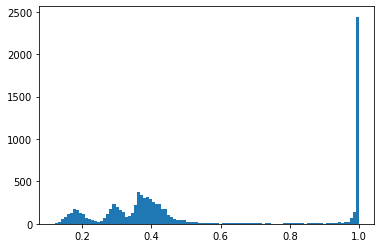

In [59]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [60]:
#%debug

In [61]:
#=====

# Predict and submit

In [62]:
def _tta(img, ops):
    # input: NxCxHxW
    if ops == 0:
        pass
    elif ops == 1:
        img = torch.flip(img, [-1])
    elif ops == 2:
        img = torch.flip(img, [-2])
    elif ops == 3:
        img = torch.flip(img, [-1, -2])
    elif ops == 4:
        img = torch.rot90(img, 1, [2, 3])
    elif ops == 5:
        img = torch.rot90(img, 3, [2, 3])
    else:
        pass
    return img

In [63]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    tta_ops = [0]
    tta_ops = [0, 1, 2]  # orig, hflip, vflip
    #tta_ops = [0, 1]  # orig, hflip
    #tta_ops = [0, 2]  # orig, vflip
    print("tta_ops:", tta_ops)
    
    preds = []
    for i, (images, _, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None

        with torch.no_grad():
            for _ops in tta_ops:
                o, _ = model( _tta(images, _ops) )  # for MultiOutput
                if outputs is None:
                    outputs = o
                else:
                    outputs += o
        outputs /= len(tta_ops)
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [64]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [65]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [66]:
# ==========================================================
# valid inference
# ==========================================================
seed = CFG.seeds[0]
valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

# tta inference
score_list = []
pred_valid = pd.DataFrame()
for fold in CFG.trn_fold:
    print(f"===== valid fold{fold} =====")
    
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
    print(pths)
    
    valid_f = valid[valid.fold == fold]
    print(valid_f.shape)
    
    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
    
    ## =============================
    ## tta alb
    ## =============================
    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
    ## =============================
    
    ## =============================
    ## tta Dataset
    ## =============================
    #_test_dataset = TrainDataset(valid_f, 
    #                             transforms=get_transforms(data="valid"),
    #                             #prob_spec_start_random=1.0,
    #                             #prob_vshift=1.0,  # CV悪化
    #                             #prob_swap_nega=1.0,  # CV悪化
    #                             is_npy=CFG.is_npy,
    #                             is_add_ch=CFG.is_add_ch,
    #                           )
    #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
    #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
    #
    #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
    ## =============================
    
    score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
    score_list.append(score)
    pred_valid = pd.concat([pred_valid, valid_f])
    
print(f"macro mean folds Score ± std: {round(np.mean(score_list), 4)} ± {round(np.std(score_list), 4)}")
tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
display(pred_valid.head())

#if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold0_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold0_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 15/15 [00:11<00:00,  1.36it/s]
TTA fold0 Score: 0.8576


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold1_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold1_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 15/15 [00:11<00:00,  1.29it/s]
TTA fold1 Score: 0.8593


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold2_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold2_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]
TTA fold2 Score: 0.8667


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold3_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold3_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]
TTA fold3 Score: 0.8468


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold4_seed0_best_score.pth']
(1800, 38)
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold4_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]
TTA fold4 Score: 0.8470
TTA oof Score: 0.8401


macro mean folds Score ± std: 0.8555 ± 0.0076


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  fold  sqrtSX  F0 type dir_name  \
5   2.253793  0.400924  0.401087          6.0     0     NaN NaN  NaN      NaN   
12  2.250381  0.398699  0.399798          9.0     0     NaN NaN  NaN      NaN   
17  2.253459  0.403756  0.401150          1.0     0     NaN NaN  NaN      NaN   
18  2.249809  0.401606  0.402489          1.0     0     NaN NaN  NaN      NaN   
32  2.257342  0.408922  0.412729          9.0     0     NaN NaN  NaN      NaN   

    F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  \
5  NaN    NaN        NaN        NaN         NaN        NaN        NaN   
12 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
17 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
18 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
32 NaN    NaN        NaN        NaN         NaN        NaN        NaN   

    l1_stddiff  h1_max/l1_max  real_sim     preds  
5          NaN            NaN       NaN  0.993270  
12         NaN            NaN       NaN  0.297553  
17         NaN            NaN       NaN  0.999508  
18         NaN            NaN       NaN  0.991860  
32         NaN            NaN       NaN  0.999055

In [67]:
#%debug

In [68]:
#=====

['./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold4_seed0_best_score.pth']
pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold0_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold1_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold2_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold3_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]


pth: ./output/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000/kqi_3090_ex075_v2_tta_pseudo_hvflip_lb0771_09501_sim0000_fold4_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.292792   
1  1.248537e+09         42746.0  0.454848   
2  1.248567e+09         55878.0  0.288296   
3  1.248537e+09         48020.0  0.401673   
4  1.248543e+09         45246.0  0.358659   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N     preds  
0         0          6.0  0.292792  
1         0          2.0  0.454848  
2         0          3.0  0.288296  
3         0          1.0  0.401673  
4         0          9.0  0.358659

target range [0.061804, 0.999656]


id    target
0     00054c878  0.292792
1     0007285a3  0.454848
2     00076c5a6  0.288296
3     001349290  0.401673
4     001a52e92  0.358659
...         ...       ...
7970  ffbce04ef  0.989346
7971  ffc2d976b  0.286926
7972  ffc905909  0.248297
7973  ffe276f3e  0.312718
7974  fffa17f67  0.274574

[7975 rows x 2 columns]

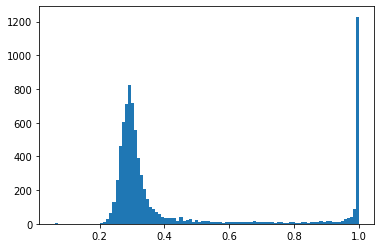

In [69]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [70]:
if CFG.is_wandb:
    wandb.finish()

In [71]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [72]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [73]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()